# Pronóstico de la cotización diaria de Repsol con GRU a una semana

In [13]:
import torch.nn as nn
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import torch.optim as optim
import investpy
from sklearn.preprocessing import StandardScaler
import shap
from sklearn.linear_model import LinearRegression
import joblib
import itertools
import copy
import csv

## Análisis Exploratorio de Datos

En esta sección se importarán los datos historicos de la cotización de Repsol y se les realizará un breve análisis descriptivo.

### Repsol

#### Importación y Análisis exploratorio

In [14]:
ticker = yf.Ticker("REP.MC")
repsol_yahoo = ticker.history(interval="1d", start="2000-08-23", end="2025-08-11")
repsol_yahoo.to_csv('data/raw/repsol_yahoo.csv')
repsol_yahoo.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-08-23 00:00:00+02:00,6.557208,6.727562,6.531222,6.710238,6856282,0.0,0.0
2000-08-24 00:00:00+02:00,6.655382,6.785314,6.383970,6.409956,6126452,0.0,0.0
2000-08-25 00:00:00+02:00,6.352205,6.438826,6.268472,6.363755,4117859,0.0,0.0
2000-08-28 00:00:00+02:00,6.363756,6.453264,6.355094,6.433053,1472493,0.0,0.0
2000-08-29 00:00:00+02:00,6.438828,6.450377,6.352207,6.430166,3339975,0.0,0.0


In [15]:
repsol_yahoo.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,6408.000000,6408.000000,6408.000000,6408.000000,6.408000e+03,6408.000000,6408.0
mean,7.901876,7.991051,7.807770,7.897935,1.004222e+07,0.002994,0.0
std,2.297465,2.312005,2.284956,2.297424,9.982333e+06,0.035281,0.0
min,3.238390,3.277551,3.057642,3.238390,0.000000e+00,0.000000,0.0
25%,6.072245,6.164520,5.987488,6.061030,5.240006e+06,0.000000,0.0
50%,8.035326,8.113012,7.923623,8.014803,7.598858e+06,0.000000,0.0
75%,9.355859,9.441445,9.249599,9.350198,1.139002e+07,0.000000,0.0
max,14.374401,14.472551,14.325327,14.432399,2.534970e+08,0.577500,0.0


**Observaciones**  
Respsol llegó a cotizar sobre los 30€ en julio de 2007, en este dataset el máximo histórico está por dejado de los 15€, esto implica que los datos no son totalmente correctos.  
Para solucionarlo se importarán con otra API.

In [16]:
i = True
while i:
    try:
        repsol = investpy.get_stock_historical_data(
            stock='rep',
            country='Spain',
            from_date='23/08/2000',
            to_date='11/08/2025'
        )
        i = False
    except:
        print("Error 105: Vuelve a intentarlo")

repsol.to_csv('data/raw/repsol_raw.csv')
repsol.head()

Error 105: Vuelve a intentarlo


,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2000-08-23,14.428,14.803,14.371,14.765,10255944,EUR
2000-08-24,14.644,14.930,14.047,14.104,9164230,EUR
2000-08-25,13.977,14.168,13.793,14.003,6159684,EUR
2000-08-28,14.003,14.200,13.983,14.155,2202623,EUR
2000-08-29,14.168,14.193,13.977,14.149,4996089,EUR


**Fecha de inicio y Fin**

In [17]:
print("Inicio: ", repsol.index[0])
print("Fin:    ", repsol.index[-1])

Inicio:  2000-08-23 00:00:00
Fin:     2025-08-11 00:00:00


**Tipos de Dato y descripciones de las columnas**

In [18]:
repsol.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6354 entries, 2000-08-23 to 2025-08-11
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Open      6354 non-null   float64
 1   High      6354 non-null   float64
 2   Low       6354 non-null   float64
 3   Close     6354 non-null   float64
 4   Volume    6354 non-null   int64  
 5   Currency  6354 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 347.5+ KB


In [19]:
repsol.describe()

,Open,High,Low,Close,Volume
count,6354.000000,6354.000000,6354.000000,6354.000000,6.354000e+03
mean,12.029586,12.163804,11.883476,12.021661,9.570898e+06
std,2.477303,2.481927,2.477019,2.481065,6.244708e+06
min,5.017000,5.222000,4.912000,5.091000,0.000000e+00
25%,10.325250,10.465500,10.165000,10.311000,5.570254e+06
50%,12.128000,12.249500,11.974000,12.114500,8.265074e+06
75%,13.700000,13.840000,13.559500,13.696750,1.186086e+07
max,26.200000,26.200000,26.200000,26.200000,1.001704e+08


**Observaciones**:
1.  Volumen tiene al menos 1 dato faltante representado como 0.
2.  Los datos van desde el 03/01/2000 hasta 25/07/2025, en total 6506 días activos.
3.  Al contrario que el yfinance, este dataset no contiene datos de dividendos, por lo que posteriormente se unirán.
4.  El máximo sigue estando por debajo de los 30€ pero la diferencia ya no es tan dispar.

#### Representación gráfica de los precios de cierre y volumen diarios

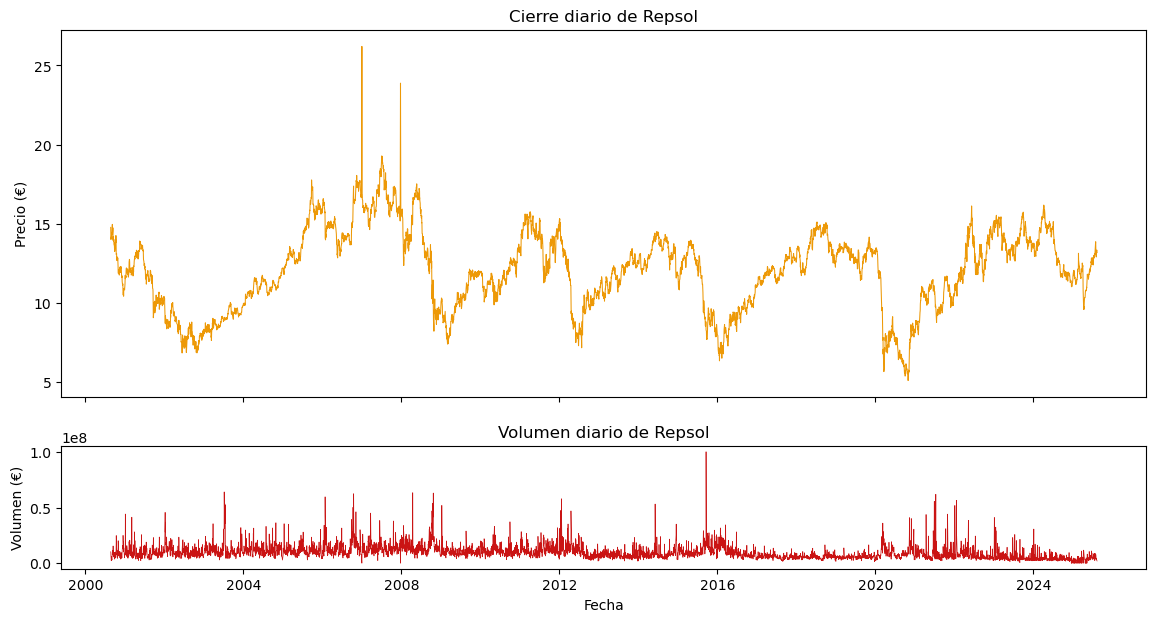

In [20]:
fig, ax = plt.subplots(2,1, sharex=True,figsize=(14,7), gridspec_kw={'height_ratios': [3, 1]})
ax = ax.flatten()
sns.lineplot(data=repsol, x=repsol.index, y='Close', color="#ed9907", lw=0.75, ax=ax[0])
ax[0].set_title('Cierre diario de Repsol')
sns.lineplot(data=repsol,x=repsol.index, y='Volume', color="#ca1414", lw=0.5, ax=ax[1])
ax[1].set_title('Volumen diario de Repsol')
plt.xlabel('Fecha')
ax[0].set_ylabel('Precio (€)')
ax[1].set_ylabel('Volumen (€)')
plt.show()

**Obervaciones**  
Hay 2 posibles outliers en el año 2007

<Axes: title={'center': 'Repsol 2007'}, xlabel='Date'>

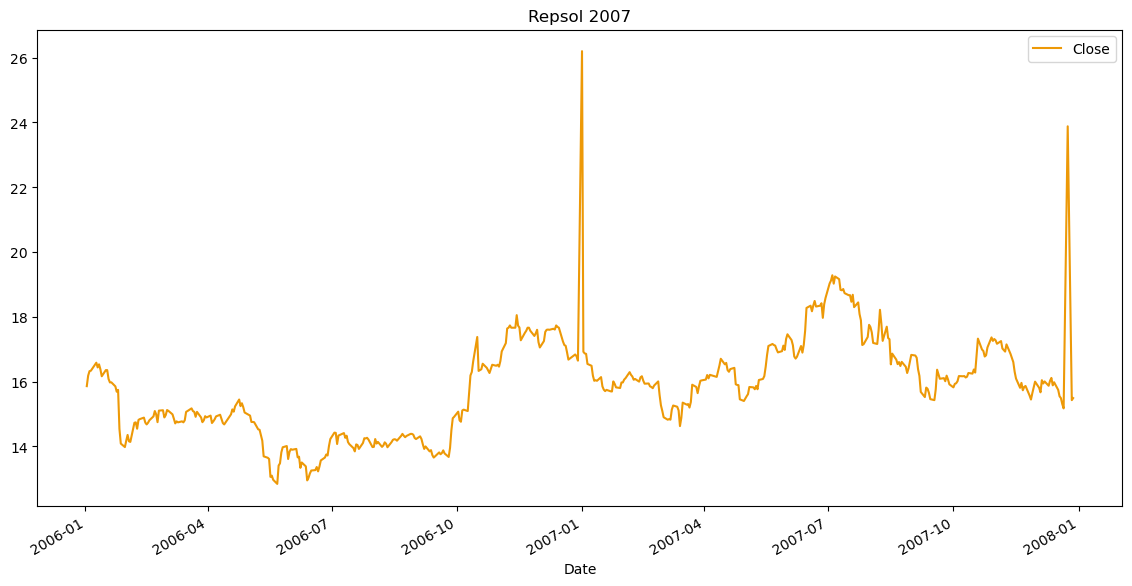

In [21]:
repsol[(repsol.index.year == 2007) | (repsol.index.year == 2006)].plot(y='Close', figsize=(14, 7), title='Repsol 2007', color='#ed9907')

**Observaciones**  
Después de comprobar esos días manualmente se ha llegado a la conclusión de que son errores.

In [ ]:
repsol = repsol[repsol['Close'] < 23]
repsol.index = repsol.index.tz_localize(None)
repsol.to_csv('data/clean/repsol_clean.csv')

### IBEX 35

In [23]:
ibex_35 = yf.Ticker("^IBEX")
ibex_35 = ibex_35.history(interval="1d", start="2000-08-23", end="2025-08-11")
ibex_35.to_csv('data/raw/ibex_35_raw.csv')
ibex_35.index = ibex_35.index.tz_localize(None)
ibex_35.to_csv('data/clean/ibex_35_clean.csv')
ibex_35.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-08-23,10934.588731,10954.088712,10695.588969,10798.088867,8254500,0.0,0.0
2000-08-24,10798.088789,10843.288939,10713.588874,10720.088867,7918200,0.0,0.0
2000-08-25,10724.689546,10899.689372,10724.689546,10818.289062,6761900,0.0,0.0
2000-08-28,10845.789123,10919.588855,10845.789123,10907.489258,3808300,0.0,0.0
2000-08-29,10907.489192,10921.989177,10783.588924,10840.588867,5063500,0.0,0.0


In [24]:
ibex_35.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6349 entries, 2000-08-23 to 2025-08-08
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          6349 non-null   float64
 1   High          6349 non-null   float64
 2   Low           6349 non-null   float64
 3   Close         6349 non-null   float64
 4   Volume        6349 non-null   int64  
 5   Dividends     6349 non-null   float64
 6   Stock Splits  6349 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 396.8 KB


In [25]:
ibex_35.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,6349.000000,6349.000000,6349.000000,6349.000000,6.349000e+03,6349.0,6349.0
mean,9674.207657,9743.948973,9593.547769,9671.952487,1.266382e+08,0.0,0.0
std,1975.325240,1979.142384,1971.572468,1977.030938,1.252904e+08,0.0,0.0
min,5294.794584,5462.594712,5266.894709,5364.494629,0.000000e+00,0.0,0.0
25%,8352.099609,8415.291005,8275.691472,8353.191406,1.978000e+05,0.0,0.0
50%,9394.599609,9452.790004,9327.599609,9386.200195,1.288509e+08,0.0,0.0
75%,10689.389524,10757.189453,10606.689586,10686.000000,2.091152e+08,0.0,0.0
max,15999.184304,16040.384459,15868.584011,15945.683594,9.752120e+08,0.0,0.0


**Observaciones**  
El dataset del Ibex35 no contiene nulos en el precio pero el Volumen los tiene representado como 0

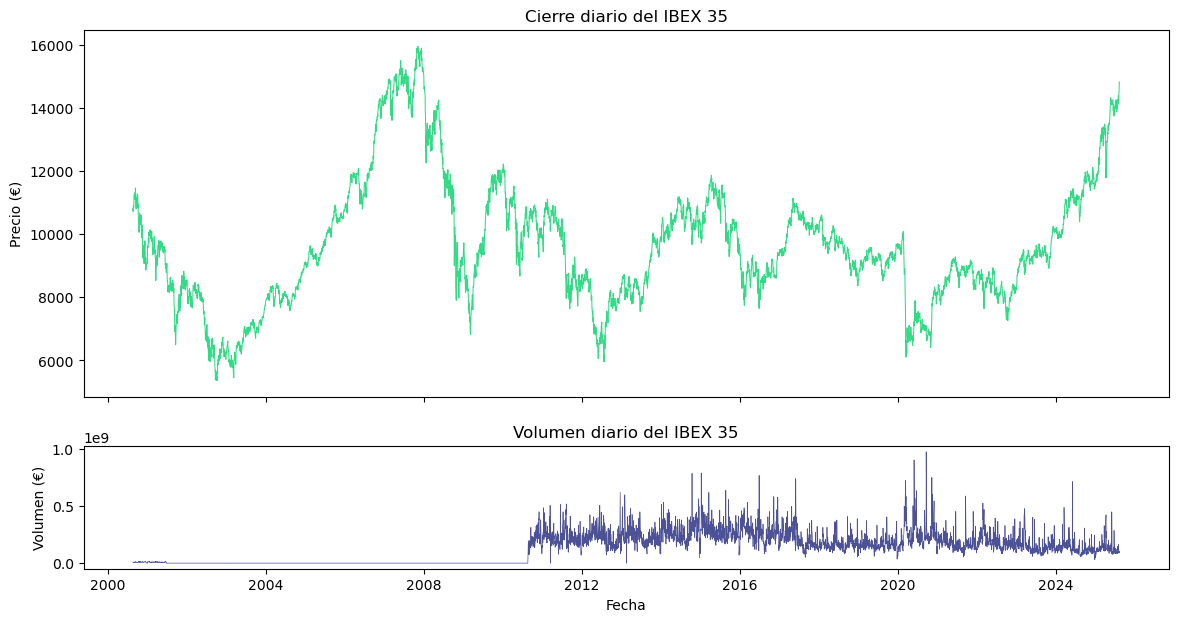

In [26]:
fig, ax = plt.subplots(2,1, sharex=True,figsize=(14,7), gridspec_kw={'height_ratios': [3, 1]})
ax = ax.flatten()
sns.lineplot(data=ibex_35, x=ibex_35.index, y='Close', color="#33DB87", lw=0.75, ax=ax[0])
ax[0].set_title('Cierre diario del IBEX 35')
sns.lineplot(data=ibex_35,x=ibex_35.index, y='Volume', color='#4d5297', lw=0.5, ax=ax[1])
ax[1].set_title('Volumen diario del IBEX 35')
plt.xlabel('Fecha')
ax[0].set_ylabel('Precio (€)')
ax[1].set_ylabel('Volumen (€)')
plt.show()

**Observaciones**  
Los datos de volumen parecen empezar en 2011 aunque se aprecia una ligera distorisión al inicio

### Petróleo

In [27]:
petroleo = yf.Ticker("CL=F")
petroleo = petroleo.history(interval="1d", end="2025-08-11", period="max")
petroleo.to_csv('data/raw/petroleo_raw.csv')
petroleo.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-08-23 00:00:00-04:00,31.950001,32.799999,31.950001,32.049999,79385,0.0,0.0
2000-08-24 00:00:00-04:00,31.900000,32.240002,31.400000,31.629999,72978,0.0,0.0
2000-08-25 00:00:00-04:00,31.700001,32.099998,31.320000,32.049999,44601,0.0,0.0
2000-08-28 00:00:00-04:00,32.040001,32.919998,31.860001,32.869999,46770,0.0,0.0
2000-08-29 00:00:00-04:00,32.820000,33.029999,32.560001,32.720001,49131,0.0,0.0


**Dolar-Euro**  
El precio de Repsol está en euros mientras que el del petróleo en dolares

In [28]:
i = True
while i:
    try:
        euro_dolar = investpy.get_currency_cross_historical_data(
            currency_cross='USD/EUR',
            from_date='23/08/2000',
            to_date='11/08/2025',
            interval='Daily')
        i = False
    except:
        print("Error 105: Vuelve a intentarlo")


euro_dolar.index = euro_dolar.index.tz_localize(None)
euro_dolar.to_csv('data/raw/dolar_euro.csv')

In [29]:
petroleo.index = petroleo.index.tz_localize(None)
petroleo['Close_Euro'] = petroleo['Close'] * euro_dolar['Close']

In [30]:
petroleo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6267 entries, 2000-08-23 to 2025-08-08
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          6267 non-null   float64
 1   High          6267 non-null   float64
 2   Low           6267 non-null   float64
 3   Close         6267 non-null   float64
 4   Volume        6267 non-null   int64  
 5   Dividends     6267 non-null   float64
 6   Stock Splits  6267 non-null   float64
 7   Close_Euro    6267 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 440.6 KB


In [31]:
petroleo.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Close_Euro
count,6267.000000,6267.000000,6267.000000,6267.000000,6.267000e+03,6267.0,6267.0,6267.000000
mean,64.737335,65.735835,63.666242,64.726692,3.035803e+05,0.0,0.0,53.424984
std,24.767887,25.031272,24.474717,24.774411,2.086182e+05,0.0,0.0,17.850849
min,-14.000000,13.690000,-40.320000,-37.630001,0.000000e+00,0.0,0.0,-34.642179
25%,46.029999,46.950001,45.139999,46.049999,1.214120e+05,0.0,0.0,39.424482
50%,64.180000,65.150002,63.180000,64.080002,2.760950e+05,0.0,0.0,52.576677
75%,82.299999,83.334999,81.119999,82.320000,3.937115e+05,0.0,0.0,67.682693
max,145.190002,147.270004,143.220001,145.289993,2.288230e+06,0.0,0.0,116.201637


In [32]:
print("Inicio: ", petroleo.index[0])
print("Fin:    ", petroleo.index[-1])

Inicio:  2000-08-23 00:00:00
Fin:     2025-08-08 00:00:00


**Observaciones**  
1.  A pesar de ser un commodity el dataset consta de dividendos y divisiones de acción, ambas evidentemente vacias.
2.  Volumen tiene al menos un dato faltante en volumen, representado como 0.
3.  Los datos van desde el 23/08/2000 hasta 25/07/2025, en total 6257 días activos, lo que implica 308 dias menos que repsol.

#### Representación gráfica de los precios de cierre y volumen diarios

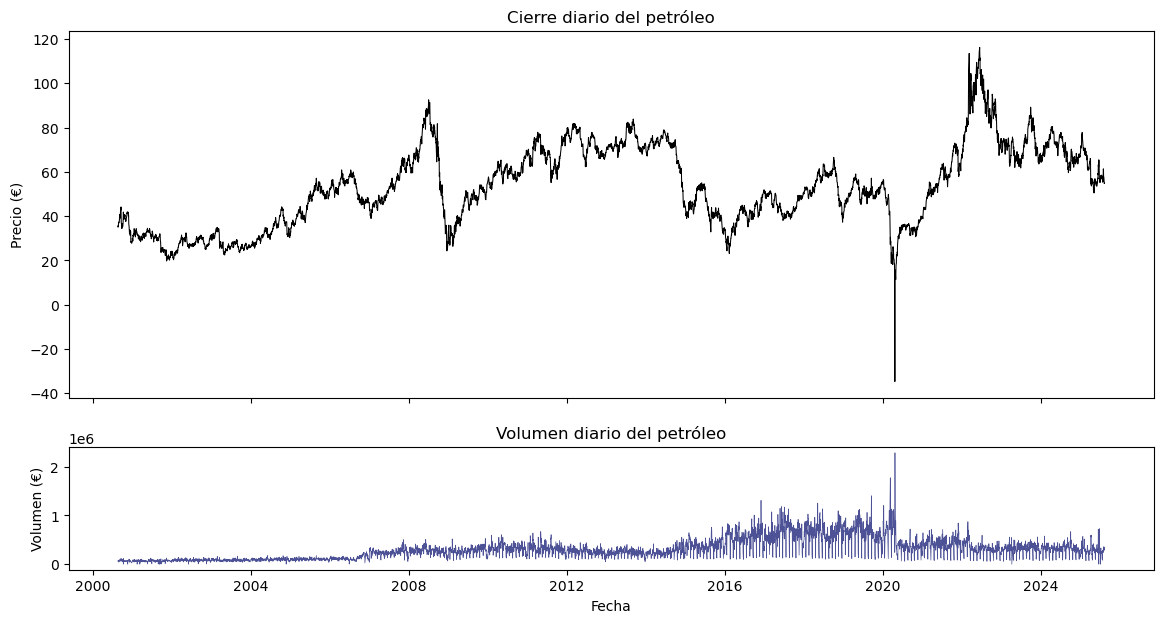

In [33]:
fig, ax = plt.subplots(2,1, sharex=True,figsize=(14,7), gridspec_kw={'height_ratios': [3, 1]})
ax = ax.flatten()
sns.lineplot(data=petroleo, x=petroleo.index, y='Close_Euro', color="#000000", lw=0.75, ax=ax[0])
ax[0].set_title('Cierre diario del petróleo')
sns.lineplot(data=petroleo,x=petroleo.index, y='Volume', color='#4d5297', lw=0.5, ax=ax[1])
ax[1].set_title('Volumen diario del petróleo')
plt.xlabel('Fecha')
ax[0].set_ylabel('Precio (€)')
ax[1].set_ylabel('Volumen (€)')
plt.show()

### Imputación de nulos

In [34]:
(repsol == 0).sum()

Open        0
High        0
Low         0
Close       0
Volume      0
Currency    0
dtype: int64

In [35]:
(petroleo == 0).sum()

Open               0
High               0
Low                0
Close              0
Volume            10
Dividends       6267
Stock Splits    6267
Close_Euro         0
dtype: int64

**Observaciones**:  
Tienen muy pocos valores sin información, inferior al 1.2%

Para rellenar los nulos se realizará una interpolación temporal

In [36]:
repsol['Volume']= repsol['Volume'].replace(0, np.nan)
repsol['Volume'] = repsol['Volume'].interpolate(method="time")
repsol['Volume'].isna().sum()

np.int64(0)

In [37]:
petroleo['Volume'] = petroleo['Volume'].replace(0, np.nan)
petroleo['Volume'] = petroleo['Volume'].interpolate(method="time")
petroleo['Volume'].isna().sum()

np.int64(0)

In [38]:
petroleo.index = petroleo.index.tz_localize(None)
petroleo.to_csv('data/clean/petroleo_clean.csv')

## Ingeniería de Características

**Dataframe de Repsol y Petroleo**  
Los indices tienen distinto huso horario lo cual impide juntarlos.

In [ ]:
repsol_yahoo = repsol_yahoo.tz_localize(None)
ibex_35.index = ibex_35.index.tz_localize(None)

In [ ]:
df = pd.DataFrame({
        'Repsol': repsol['Close'],
        'Petroleo': petroleo['Close_Euro'],
        'Repsol_Volume': repsol['Volume'],
        'Dividendos': repsol_yahoo['Dividends'],
        'IBEX_35': ibex_35['Close']
        })
df.dropna(inplace=True)
df.head()

,Repsol,Petroleo,Repsol_Volume,Dividendos,IBEX_35
Date,,,,,
2000-08-23,14.765,35.565884,10255944.0,0.0,10798.088867
2000-08-24,14.104,35.061854,9164230.0,0.0,10720.088867
2000-08-25,14.003,35.524219,6159684.0,0.0,10818.289062
2000-08-28,14.155,36.528430,2202623.0,0.0,10907.489258
2000-08-29,14.149,36.669305,4996089.0,0.0,10840.588867


### Spread

In [29]:
def calcular_spread(serie_1, serie_2):
    """
    Parámetros:
    serie_1: pd.Series - La primera serie temporal.
    serie_2: pd.Series - La segunda serie temporal.

    Devuelve:
    pd.Series - La serie del spread calculado.
    """
    X = serie_2.values.reshape(-1, 1)
    y = serie_1.values

    model = LinearRegression().fit(X, y)
    beta = model.coef_[0]

    spread = serie_1 - beta * serie_2

    return spread

df['Spread_petroleo'] = calcular_spread(df['Repsol'], df['Petroleo'])
df['Spread_ibex_35'] = calcular_spread(df['Repsol'], df['IBEX_35'])

**Observaciones**  
El spread entre los precios absoultos de Repsol y el petróleo parecen estar cointegrados

#### Representación gráfica del Sperad

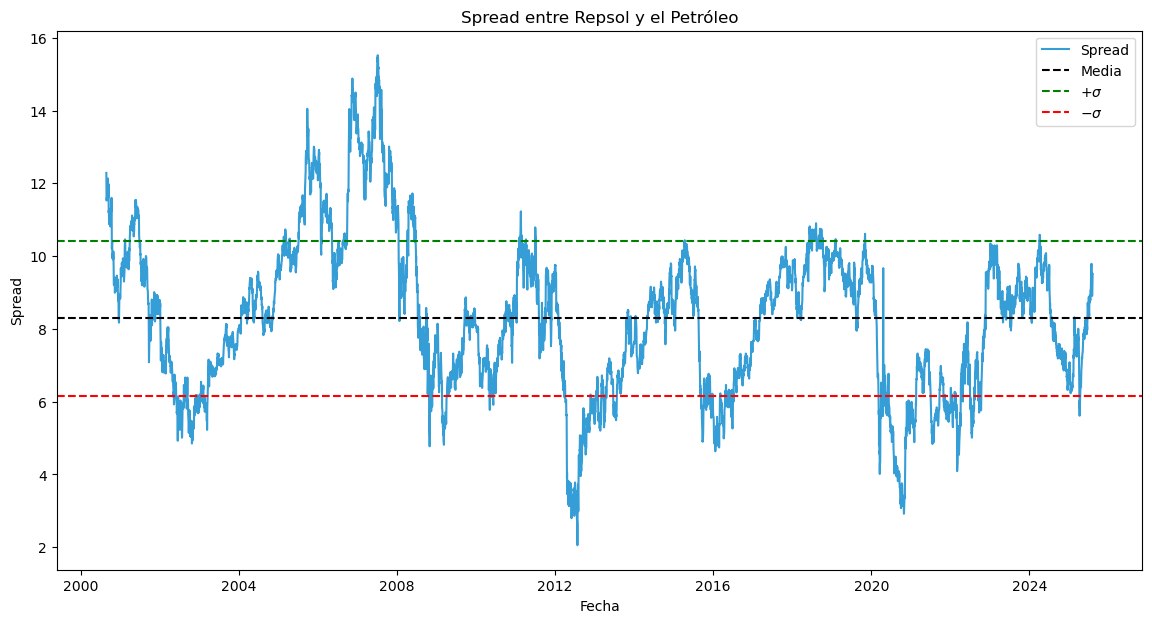

In [30]:
plt.figure(figsize=(14, 7))
sns.lineplot(x=df.index, y=df['Spread_petroleo'], label='Spread', color="#359ed6")

plt.axhline(y=df['Spread_petroleo'].mean(), color='k', linestyle='--', lw=1.5, label='Media')
plt.axhline(y=df['Spread_petroleo'].mean() + df['Spread_petroleo'].std(), color='g', linestyle='--',  label=r'$+\sigma$')
plt.axhline(y=df['Spread_petroleo'].mean() - df['Spread_petroleo'].std(), color='r', linestyle='--', label=r'$-\sigma$')

plt.legend()
plt.title('Spread entre Repsol y el Petróleo')
plt.xlabel('Fecha')
plt.ylabel('Spread')
plt.show()

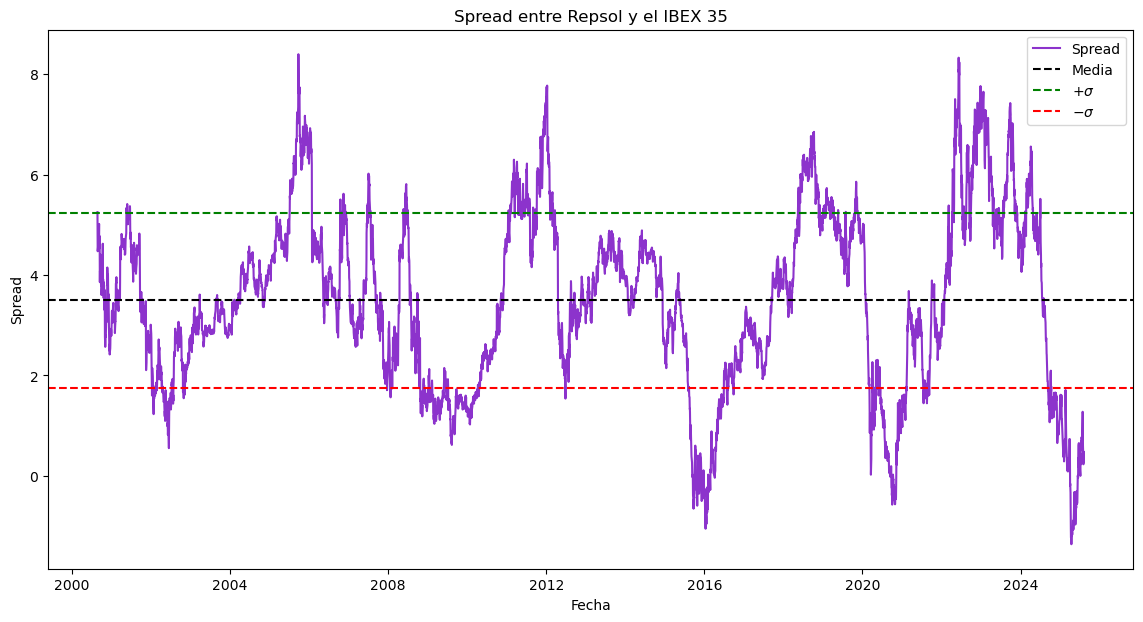

In [31]:
plt.figure(figsize=(14, 7))
sns.lineplot(x=df.index, y=df['Spread_ibex_35'], label='Spread', color="#8c33cc")

plt.axhline(y=df['Spread_ibex_35'].mean(), color='k', linestyle='--', lw=1.5, label='Media')
plt.axhline(y=df['Spread_ibex_35'].mean() + df['Spread_ibex_35'].std(), color='g', linestyle='--',  label=r'$+\sigma$')
plt.axhline(y=df['Spread_ibex_35'].mean() - df['Spread_ibex_35'].std(), color='r', linestyle='--', label=r'$-\sigma$')

plt.legend()
plt.title('Spread entre Repsol y el IBEX 35')
plt.xlabel('Fecha')
plt.ylabel('Spread')
plt.show()

In [32]:
df.describe()

,Repsol,Petroleo,Repsol_Volume,Dividendos,IBEX_35,Spread_petroleo,Spread_ibex_35
count,6175.000000,6175.000000,6.175000e+03,6175.000000,6175.000000,6175.000000,6175.000000
mean,12.014881,53.522181,9.658138e+06,0.002920,9674.579291,8.285793,3.494871
std,2.470315,17.823446,6.270641e+06,0.034896,1978.912174,2.135492,1.750795
min,5.091000,-34.642179,2.000000e+02,0.000000,5364.494629,2.053285,-1.362277
25%,10.311000,39.618336,5.652811e+06,0.000000,8353.645508,6.726693,2.297188
50%,12.112000,52.648342,8.354469e+06,0.000000,9387.200195,8.341802,3.470023
75%,13.691000,67.704030,1.193392e+07,0.000000,10688.144531,9.663259,4.717209
max,19.244000,116.201637,1.001704e+08,0.577500,15945.683594,15.521475,8.401542


#### Dias desde el dividendo

In [33]:
dia = 0
dias = []
for div in df['Dividendos']:
    if div != 0:
        dia = 0
    else:
        dia += 1
    dias.append(dia)

df['Dias_desde_dividendo'] = dias
df['Dias_desde_dividendo'].head()

Date
2000-08-23    1
2000-08-24    2
2000-08-25    3
2000-08-28    4
2000-08-29    5
Name: Dias_desde_dividendo, dtype: int64

#### Mes

In [34]:
df['Mes'] = df.index.month
df['Mes'].head()

Date
2000-08-23    8
2000-08-24    8
2000-08-25    8
2000-08-28    8
2000-08-29    8
Name: Mes, dtype: int32

#### Dia de la semana

In [35]:
df['Dia_semana'] = df.index.dayofweek
df['Dia_semana'].head()

Date
2000-08-23    2
2000-08-24    3
2000-08-25    4
2000-08-28    0
2000-08-29    1
Name: Dia_semana, dtype: int32

#### Volatilidad

In [36]:
df['Volatilidad_semana_repsol'] = df['Repsol'].rolling(window=5).std()
df['Volatilidad_mes_repsol'] = df['Repsol'].rolling(window=21).std()


#### Exponential Moving Average (EMA)

In [37]:
df['EMA_semana_repsol'] = df['Repsol'].ewm(span=5, adjust=False).mean()

#### Relative Strenght Index (RSI)

In [38]:
def calcular_rsi(serie, periodo=14):
    """
    Parámetros:
    serie (pd.Series): Serie de pandas con valores numéricos.
    periodo (int): Número de periodos para el cálculo del RSI.

    Devuelve:
    pd.Series: Serie con el RSI calculado.

    Calcula el Relative Strength Index (RSI) de una serie temporal.
    """
    delta = serie.diff()
    ganancia = (delta.where(delta > 0, 0)).rolling(window=periodo).mean()
    perdida = (-delta.where(delta < 0, 0)).rolling(window=periodo).mean()
    
    rs = ganancia / perdida
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

In [39]:
df['RSI_repsol'] = calcular_rsi(df['Repsol'])

#### Variable Objetivo: Precio de Repsol en 1 semana

In [40]:
df['Repsol_prox_semana'] = df['Repsol'].shift(-5)

In [41]:
assert df['Repsol_prox_semana'].iloc[0] == df['Repsol'].iloc[5]

#### Limpieza de nulos

In [42]:
df.isnull().sum()

Repsol                        0
Petroleo                      0
Repsol_Volume                 0
Dividendos                    0
IBEX_35                       0
Spread_petroleo               0
Spread_ibex_35                0
Dias_desde_dividendo          0
Mes                           0
Dia_semana                    0
Volatilidad_semana_repsol     4
Volatilidad_mes_repsol       20
EMA_semana_repsol             0
RSI_repsol                   13
Repsol_prox_semana            5
dtype: int64

**Observaciones**  
Las nuevas características tienen hasa un máximo de 20 nulos, usualmente debido que se utilizan valores anteriores para calcular el presente,por lo que no puede calcularlos en las primeras $n$ filas.

In [43]:
df.dropna(inplace=True)

In [44]:
df.columns

Index(['Repsol', 'Petroleo', 'Repsol_Volume', 'Dividendos', 'IBEX_35',
       'Spread_petroleo', 'Spread_ibex_35', 'Dias_desde_dividendo', 'Mes',
       'Dia_semana', 'Volatilidad_semana_repsol', 'Volatilidad_mes_repsol',
       'EMA_semana_repsol', 'RSI_repsol', 'Repsol_prox_semana'],
      dtype='object')

### Procesamiento

In [45]:
train_sel = df[:int(len(df)*0.7)]
val_sel = df[int(len(df)*0.7):int(len(df)*0.8)]
test_sel = df[int(len(df)*0.8):]

train_sel.shape, test_sel.shape

((4305, 15), (1230, 15))

In [46]:
X_sel_train_prescaled = train_sel.drop(columns=['Repsol_prox_semana']).copy()
y_sel_train_prescaled = train_sel['Repsol_prox_semana'].copy()

X_sel_val_prescaled = val_sel.drop(columns=['Repsol_prox_semana']).copy()
y_sel_val_prescaled = val_sel['Repsol_prox_semana'].copy()

X_sel_test_prescaled = test_sel.drop(columns=['Repsol_prox_semana']).copy()
y_sel_test_prescaled = test_sel['Repsol_prox_semana'].copy()

# Initialize scalers
scaler_X_sel = StandardScaler()
scaler_y = StandardScaler()

# Fit and transform X data
X_sel_train_scaled = scaler_X_sel.fit_transform(X_sel_train_prescaled)
X_sel_val_scaled = scaler_X_sel.transform(X_sel_val_prescaled)
X_sel_test_scaled = scaler_X_sel.transform(X_sel_test_prescaled)

# Fit and transform y data (reshape needed for 1D arrays)
y_sel_train_scaled = scaler_y.fit_transform(y_sel_train_prescaled.values.reshape(-1, 1)).flatten()
y_sel_val_scaled = scaler_y.transform(y_sel_val_prescaled.values.reshape(-1, 1)).flatten()
y_sel_test_scaled = scaler_y.transform(y_sel_test_prescaled.values.reshape(-1, 1)).flatten()

# Save the scalers
joblib.dump(scaler_X_sel, 'modelos/scalers/scaler_X_sel.pkl')
joblib.dump(scaler_y, 'modelos/scalers/scaler_y.pkl')

# Convert scaled arrays back to DataFrames for saving
X_sel_train_scaled_df = pd.DataFrame(X_sel_train_scaled, index=X_sel_train_prescaled.index, columns=X_sel_train_prescaled.columns)
X_sel_val_scaled_df = pd.DataFrame(X_sel_val_scaled, index=X_sel_val_prescaled.index, columns=X_sel_val_prescaled.columns)
X_sel_test_scaled_df = pd.DataFrame(X_sel_test_scaled, index=X_sel_test_prescaled.index, columns=X_sel_test_prescaled.columns)


# Display first few rows of scaled data
X_sel_train_scaled_df.head()

,Repsol,Petroleo,Repsol_Volume,Dividendos,IBEX_35,Spread_petroleo,Spread_ibex_35,Dias_desde_dividendo,Mes,Dia_semana,Volatilidad_semana_repsol,Volatilidad_mes_repsol,EMA_semana_repsol,RSI_repsol
Date,,,,,,,,,,,,,,
2000-09-21,0.767166,-0.637668,-0.728811,-0.085667,0.486893,1.209751,0.691244,-1.007821,0.717286,0.698263,-0.386975,-0.066024,0.811804,-0.310492
2000-09-22,0.694176,-0.764404,-0.220881,-0.085667,0.594196,1.193763,0.434399,-0.983521,0.717286,1.415349,-0.544691,-0.040534,0.773416,-0.723138
2000-09-25,0.666408,-0.835234,-0.752622,-0.085667,0.655776,1.199641,0.310867,-0.959222,0.717286,-1.452994,-0.187140,0.088302,0.738531,-0.881618
2000-09-26,0.653714,-0.858524,-1.172295,-0.085667,0.559346,1.197521,0.409347,-0.934922,0.717286,-0.735908,0.000395,0.204718,0.711026,-1.287143
2000-09-27,0.590641,-0.859460,-0.658060,-0.085667,0.560106,1.126282,0.301783,-0.910623,0.717286,-0.018822,-0.123195,0.384782,0.671579,-1.503747


#### Creación de las secuencias

In [47]:
def crear_secuencias(df, seq_length):
    """
    Parámetros:
    - df (pd.DataFrame): Datos de entrada
    - seq_length (int): Longitud de la secuencia
    Devuelve:
    - x (np.ndarray): Array de datos secuenciales
    """
    x = []

    for i in range(len(df) - (seq_length)):
        
        x_secuencial = df.iloc[i:(i+seq_length)].values
        x.append(x_secuencial)

    return np.array(x)

In [48]:
seq_len = 20

X_sel_train = crear_secuencias(X_sel_train_scaled_df, seq_length=seq_len)
y_sel_train = y_sel_train_scaled[seq_len:]

X_sel_val = crear_secuencias(X_sel_val_scaled_df, seq_length=seq_len)
y_sel_val = y_sel_val_scaled[seq_len:]

X_sel_test = crear_secuencias(X_sel_test_scaled_df, seq_length=seq_len)
y_sel_test = y_sel_test_scaled[seq_len:]

X_sel_train.shape, y_sel_train.shape, X_sel_val.shape, y_sel_val.shape, X_sel_test.shape, y_sel_test.shape

((4285, 20, 14), (4285,), (595, 20, 14), (595,), (1210, 20, 14), (1210,))

#### Conversión a tensor

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

X_sel_tensor_train = torch.from_numpy(X_sel_train).float().to(device)

X_sel_tensor_test = torch.from_numpy(X_sel_test).float().to(device)

X_sel_tensor_val = torch.from_numpy(X_sel_val).float().to(device)

y_sel_tensor_val = torch.from_numpy(y_sel_val).float().to(device)

y_sel_tensor_train = torch.from_numpy(y_sel_train).float().to(device)

y_sel_tensor_test = torch.from_numpy(y_sel_test).float().to(device)

Train_sel_dataset = torch.utils.data.TensorDataset(
    X_sel_tensor_train, 
    y_sel_tensor_train
)

Train_sel_dataset[:][0].shape, Train_sel_dataset[:][1].shape

cuda


(torch.Size([4285, 20, 14]), torch.Size([4285]))

### Modelo GRU para Selección de Variables

In [50]:
class modelo_GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, linear_size, dropout, bidirectional=True):
        super(modelo_GRU, self).__init__()
        self.gru = nn.GRU(input_size=int(input_size), 
                          hidden_size=int(hidden_size), 
                          num_layers=int(num_layers), 
                          batch_first=True, 
                          bidirectional=bool(bidirectional))

        self.dropout = nn.Dropout(dropout)

        if bidirectional:
            hidden_size *= 2
            
        self.batch_norm = nn.BatchNorm1d(hidden_size)
            
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, linear_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(linear_size, 1)
        )

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.dropout(out[:, -1, :])
        out = self.batch_norm(out)
        out = self.fc(out)
        return out

In [51]:
def entrenar_modelo(model, train_dataset, X_tensor_val, y_tensor_val, epochs=250, batch_size=64, learning_rate=0.03, scheduler=True, paciencia_scheduler=10, early_stopping=True, paciencia_early_stopping=30, show=True):
    """
    Entrena el modelo GRU con los datos de entrenamiento.
    
    Parámetros:
    - model (nn.Module): Instancia del modelo GRU.
    - train_dataset (TensorDataset): Dataset de entrenamiento.
    - X_tensor_val (Tensor): Tensor de características de validación.
    - y_tensor_val (Tensor): Tensor de etiquetas de validación.
    - epochs (int): Número de épocas para entrenar.
    - batch_size (int): Tamaño del lote para el entrenamiento.
    - learning_rate (float): Tasa de aprendizaje para el optimizador.
    - scheduler (bool): Indica si se debe utilizar un programador de tasa de aprendizaje.
    - paciencia_scheduler (int): Número de épocas para esperar antes de reducir la tasa de aprendizaje.
    - early_stopping (bool): Indica si se debe utilizar la detención temprana.
    - paciencia_early_stopping (int): Número de épocas para esperar antes de detener el entrenamiento.
    - show (bool): Indica si se deben mostrar los mensajes de entrenamiento.

    Devuelve:
    - model (nn.Module): Modelo entrenado.
    """
    torch.manual_seed(27)
    
    model = model.to(device)
    X_tensor_val = X_tensor_val.to(device)
    y_tensor_val = y_tensor_val.to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate,)
    criterion = nn.L1Loss()
    if scheduler:
        step_lr = optim.lr_scheduler.StepLR(optimizer, step_size=paciencia_scheduler, gamma=0.75)

    if early_stopping:
        mejor_perdida = float('inf')
        epochs_sin_mejorar = 0
        mejor_modelo = None

    generador = torch.Generator()
    generador.manual_seed(27)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=generador)

    for epoch in range(epochs):
        model.train()
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs.squeeze(), y_batch)
            loss.backward()
            optimizer.step()

        if scheduler:
            step_lr.step()

        if early_stopping:
            with torch.no_grad():
                model.eval()
                val_outputs = model(X_tensor_val)
                val_loss = criterion(val_outputs.squeeze(), y_tensor_val)
           
            if val_loss.item() < mejor_perdida:
                mejor_perdida = val_loss.item()
                epochs_sin_mejorar = 0
                mejor_modelo = copy.deepcopy(model.state_dict())
            else:
                epochs_sin_mejorar += 1

                if epochs_sin_mejorar >= paciencia_early_stopping:
                    if show:
                        print(f'No se observó mejora en {paciencia_early_stopping} épocas. Deteniendo entrenamiento.')

                    model.load_state_dict(mejor_modelo)
                    return model

        if show and ((epoch + 1) % 10 == 0):
            print(f'Época [{epoch + 1}/{epochs}], Pérdida: {loss.item():.4f}')
            if early_stopping:
                print(f'Mejor pérdida de validación actual:{mejor_perdida:.4f}')
    if early_stopping and mejor_modelo:
        model.load_state_dict(mejor_modelo)
    return model

In [52]:
sns.set_style("darkgrid")

def calcular_mae(y_true, y_pred):
    mae = np.mean(np.abs(y_pred - y_true))
    return mae

def calcular_mape(y_true, y_pred):
    mape = np.mean(np.abs((y_pred - y_true) / y_true) * 100)
    return mape

def evaluar_modelo(model, X_seq_tensor, y, scaler=None, titulo='Evaluación del Modelo', show=True):
    """
    Evalúa el modelo entrenado calculando métricas y mostrando gráficos.

    Parámetros:
    - model (nn.Module): Modelo entrenado de PyTorch.
    - X_seq_tensor (torch.Tensor): Tensor con las secuencias de entrada (shape: [N, seq_len, n_features]).
    - y (np.ndarray | torch.Tensor): Valores reales de la variable objetivo.
    - scaler (object, opcional): Escalador (por ejemplo StandardScaler) usado para desescalar y_pred y y. Default: None.
    - titulo (str): Título que se mostrará en la figura. Default: 'Evaluación del Modelo'.
    - show (bool): Si True imprime métricas y muestra los gráficos. Default: True.

    Devuelve:
    - mae (float): Mean Absolute Error entre valores reales y predichos (en la escala original si se proporciona scaler).
    - mape (float): Mean Absolute Percentage Error (%) (en la escala original si se proporciona scaler).
    """
    
    with torch.inference_mode():
        model.eval()
        model = model.to(device)
        y_pred = model(X_seq_tensor).squeeze().cpu().numpy()

    if type(y) is torch.Tensor:
        y = y.cpu().numpy()

    if scaler:
        y_pred = scaler.inverse_transform([y_pred]).flatten()
        y = scaler.inverse_transform([y]).flatten()

    mae = calcular_mae(y, y_pred)
    mape = calcular_mape(y, y_pred)

    if show:

        print(f'MAE: {mae:.4f}')
        print(f'MAPE: {mape:.4f}%')
        
        fig, axs = plt.subplots(3, 1, figsize=(14, 14))

        # Gráfico de líneas: Real vs Predicción
        axs[0].plot(y, label='Real', color="#1C9DE2", lw=0.75)
        axs[0].plot(y_pred, label='Predicción', color="#ff1414", alpha=0.5, lw=0.75)
        axs[0].set_title('Análisis Cronológico de la Precisión del Modelo')
        axs[0].set_xlabel('Fecha')
        axs[0].set_ylabel('Valor de la variable objetivo')
        axs[0].legend()

        # Gráfico de dispersión: Predicciones vs Valores Reales
        sns.scatterplot(x=y, y=y_pred, color='#1C9DE2', alpha=0.25, ax=axs[1], size=3, legend=False)
        axs[1].plot([y.min(), y.max()], [y.min(), y.max()], color='#ff1414', linestyle='--')
        axs[1].set_title('Desempeño Global del Modelo: Valores Reales vs Estimados')
        axs[1].set_xlim(y.min(), y.max())
        axs[1].set_ylim(y.min(), y.max())
        axs[1].set_xlabel('Valores Reales')
        axs[1].set_ylabel('Predicciones')

        # Histograma del error porcentual
        sns.histplot( (y_pred - y) / y * 100, bins=100, color="#aa00ff", ax=axs[2], linewidth=1.5)
        axs[2].set_title('Distribución del Error Porcentual')
        axs[2].set_xlabel('Error Porcentual (%)')
        axs[2].set_ylabel('Frecuencia')

        plt.tight_layout()
        plt.suptitle(titulo, fontsize=16, y=1.02)
        plt.show()


    return mae, mape

In [ ]:
hidden_sizes = [2, 4, 8, 16]
num_layers = [1, 2, 4]
dropouts = [0, 0.125, 0.25]
linear_sizes = [2, 4, 8, 16]

param_grid = {
    'hidden_size': hidden_sizes,
    'num_layers': num_layers,
    'dropout': dropouts,
    'linear_size': linear_sizes
}

df_search_sel_results = pd.DataFrame(columns=list(param_grid.keys()) + ['mae_train', 'mae_val', 'mape_train', 'mape_val'])

In [ ]:
i = 1
best_mape = 10
for params in itertools.product(*param_grid.values()):

    hidden_size, num_layers, dropout, linear_size = params

    torch.manual_seed(27)

    model = modelo_GRU(input_size=X_sel_tensor_train.shape[2],
                       hidden_size=hidden_size,
                       num_layers=num_layers,
                       linear_size=linear_size,
                       dropout=dropout)

    model = entrenar_modelo(model, Train_sel_dataset, X_tensor_val=X_sel_tensor_val, y_tensor_val=y_sel_tensor_val, show=False, scheduler=True, paciencia_scheduler=10, early_stopping=True, epochs=200, paciencia_early_stopping=30, learning_rate=0.003)
    mae_train, mape_train = evaluar_modelo(model, X_sel_tensor_train, y_sel_train, scaler=scaler_y, show=False)
    mae_val, mape_val = evaluar_modelo(model, X_sel_tensor_val, y_sel_val, scaler=scaler_y, show=False)

    if mape_val < best_mape:
        best_mape = mape_val
        best_model = model
        print(f"Modelo {i}: MAE Train = {mae_train:.4f}, MAE Val = {mae_val:.4f}, MAPE Train = {mape_train:.4f}%, MAPE Val = {mape_val:.4f}%")

    df_search_sel_results.loc[i] = {
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'dropout': dropout,
        'linear_size': linear_size,
        'mae_train': mae_train,
        'mae_val': mae_val,
        'mape_train': mape_train,
        'mape_val': mape_val
    }
    i += 1
    

df_search_sel_results = df_search_sel_results.sort_values(by='mae_val').reset_index(drop=True)
df_search_sel_results.head()
df_search_sel_results.to_csv('data/grid_search/df_sel_search_results.csv', index=False)

torch.save(best_model, 'modelos/gru/gru_sel.pt')

In [55]:
parametros = pd.read_csv('data/grid_search/df_sel_search_results.csv')
parametros.head()

,hidden_size,num_layers,dropout,linear_size,mae_train,mae_val,mape_train,mape_val
0,8,1,0.000,16,0.379115,0.399105,3.321986,3.836864
1,2,2,0.000,4,0.355298,0.402191,3.107611,3.930173
2,2,1,0.000,2,0.405423,0.408478,3.409943,4.041616
3,16,4,0.125,16,0.423729,0.417688,3.712611,4.029918
4,8,1,0.000,8,0.380380,0.422057,3.339271,4.036362


In [56]:
gru_sel = torch.load('modelos/gru/gru_sel.pt')

C:\Users\rubi6\AppData\Local\Temp\ipykernel_2284\2277148387.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gru_sel = torch.load('modelos/gru/gru_sel.pt')


MAE: 0.3791
MAPE: 3.3220%


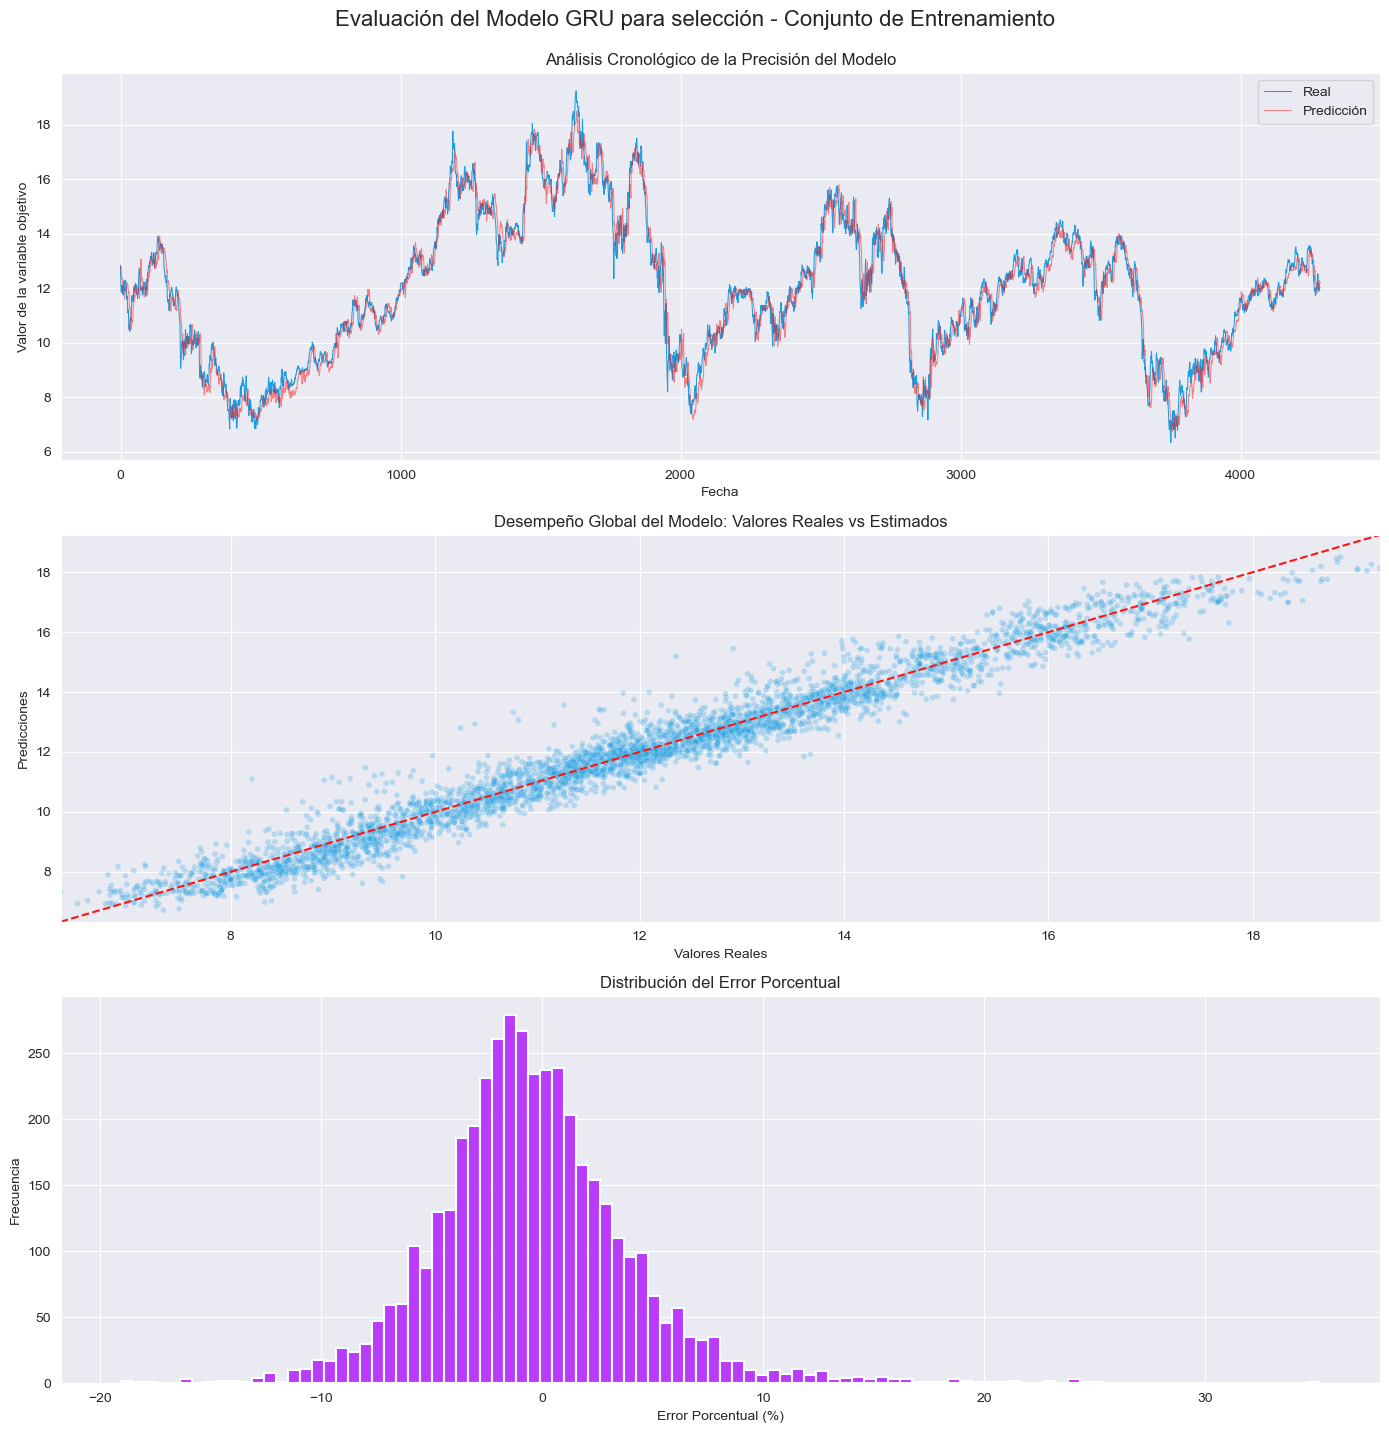

In [57]:
mae_train_gru, mape_train_gru = evaluar_modelo(gru_sel, X_sel_tensor_train, y_sel_train, scaler=scaler_y, titulo='Evaluación del Modelo GRU para selección - Conjunto de Entrenamiento')

MAE: 0.3991
MAPE: 3.8369%


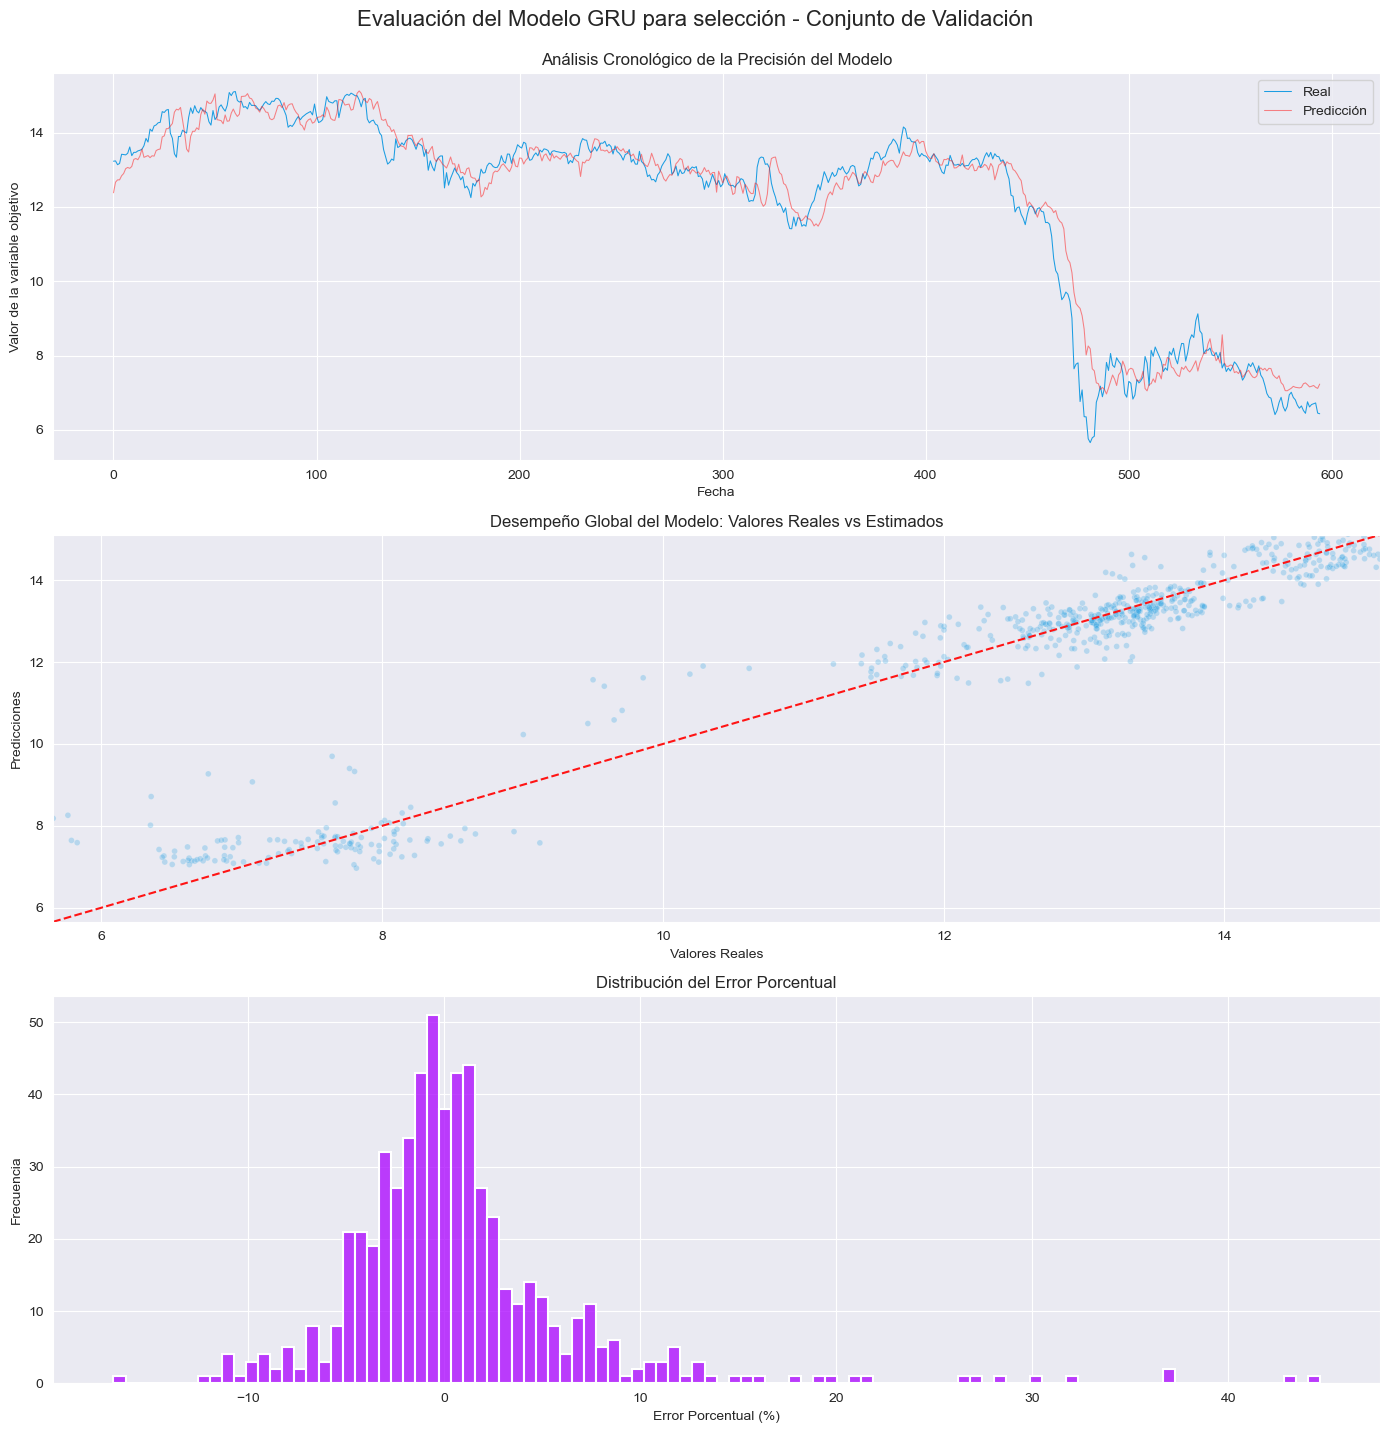

In [58]:
mae_val_gru, mape_val_gru = evaluar_modelo(gru_sel, X_sel_tensor_val, y_sel_val, scaler=scaler_y, titulo='Evaluación del Modelo GRU para selección - Conjunto de Validación') 

MAE: 0.4944
MAPE: 4.3741%


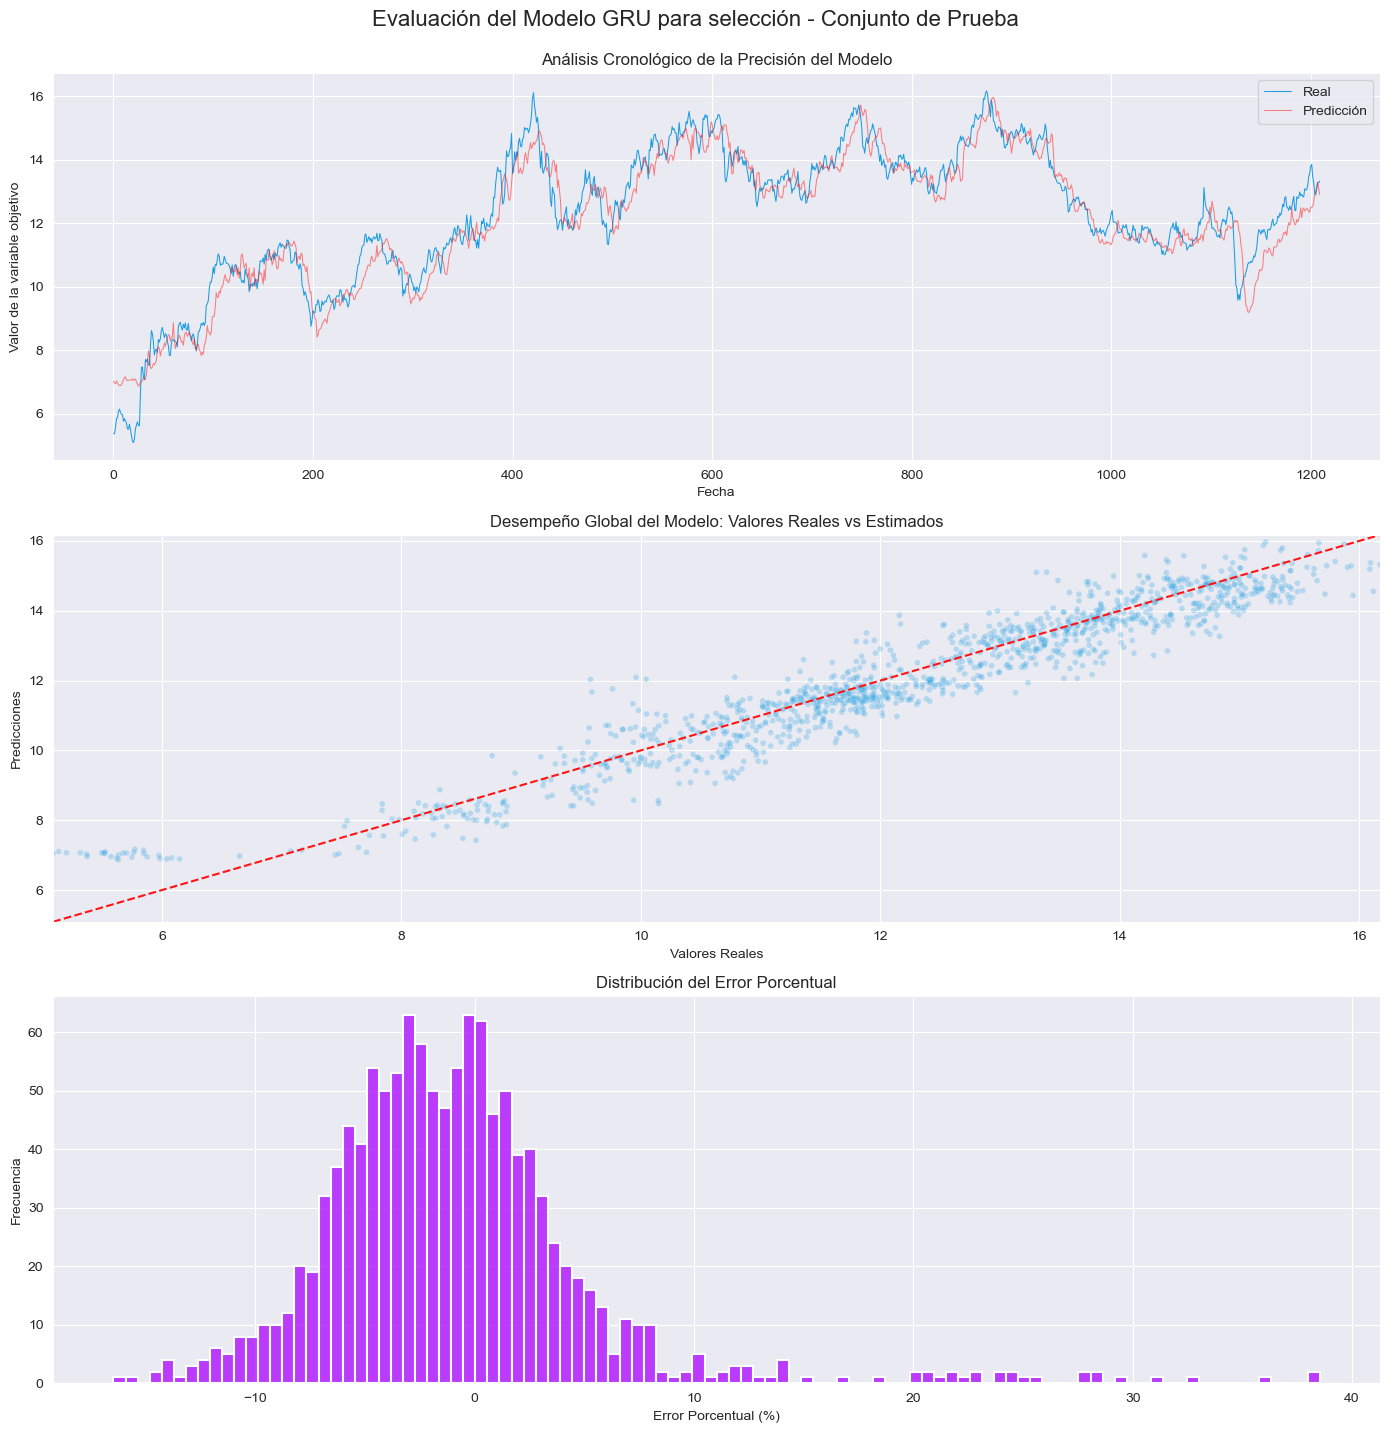

In [59]:
mae_test_gru, mape_test_gru = evaluar_modelo(gru_sel, X_sel_tensor_test, y_sel_test, scaler=scaler_y, titulo='Evaluación del Modelo GRU para selección - Conjunto de Prueba')

### SHAP

In [61]:
gru_sel.cpu()

index_background = np.linspace(0, len(X_sel_tensor_train) - 1, 500, dtype=int)
X_background = X_sel_tensor_train[index_background].cpu()

explainer = shap.GradientExplainer(gru_sel, X_background)
joblib.dump(explainer, 'modelos/shap/explainer_shap.pkl')

index_explain = np.linspace(0, len(X_sel_tensor_train) - 1, 750, dtype=int)

X_sel_explain = X_sel_tensor_train[index_explain].cpu()

shap_values = explainer(X_sel_explain)

shap_values.shape

(750, 20, 14, 1)

In [62]:
shap_values = shap_values.values.squeeze(-1)  
shap_values.shape

(750, 20, 14)

 - Muestras:  Eje 0  
 - Periodos:  Eje 1  
 - Variables: Eje 2

In [65]:
# El orden de los periodos es inverso al de los datos originales, por lo que se invierte el orden.
shap_values = np.flip(shap_values, axis=1)

joblib.dump(shap_values, 'data/shap/shap_values.pkl')

['data/shap/shap_values.pkl']

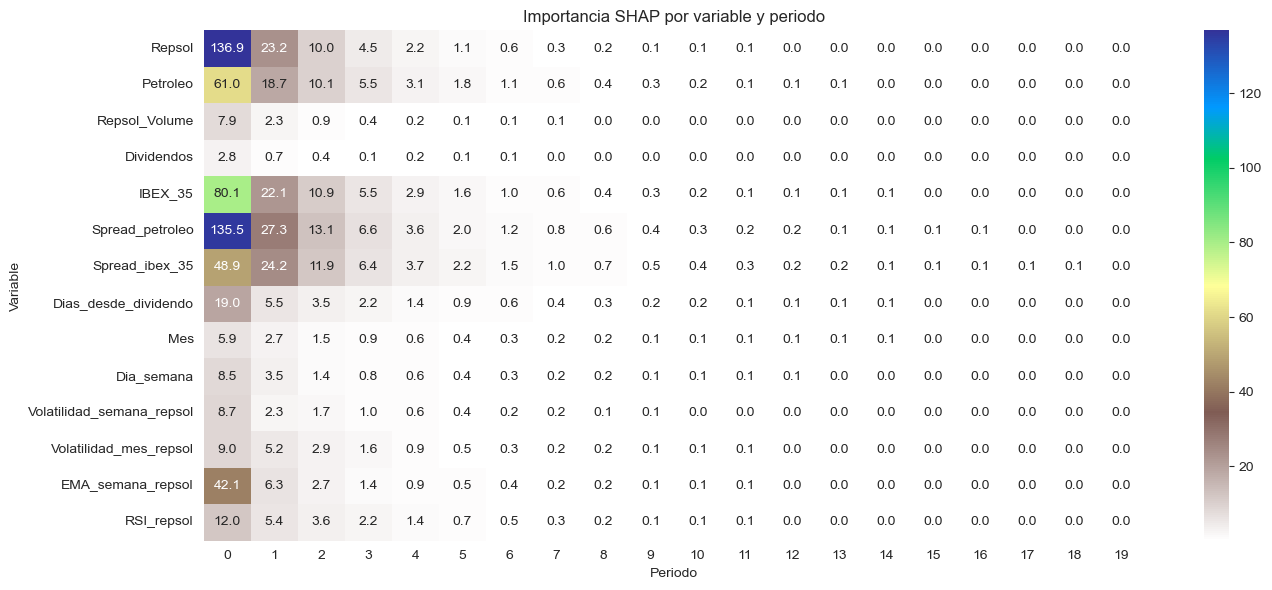

In [66]:
# Promedio por variable y por paso temporal
importance_time = np.abs(shap_values).sum(axis=0)

df_heat = pd.DataFrame(importance_time, columns=X_sel_train_scaled_df.columns) 
plt.figure(figsize=(14, 6))
sns.heatmap(df_heat.T, cmap='terrain_r', annot=True, fmt=".1f")
plt.title("Importancia SHAP por variable y periodo")
plt.xlabel("Periodo")
plt.ylabel("Variable")
plt.tight_layout() 
plt.show()


In [67]:
importancia_por_variable = np.abs(shap_values).sum(axis=(0, 1)) 

importancia_por_variable = pd.Series(importancia_por_variable, index=X_sel_train_scaled_df.columns)
importancia_por_variable = importancia_por_variable.sort_values(ascending=False)
importancia_por_variable = importancia_por_variable / importancia_por_variable.max()

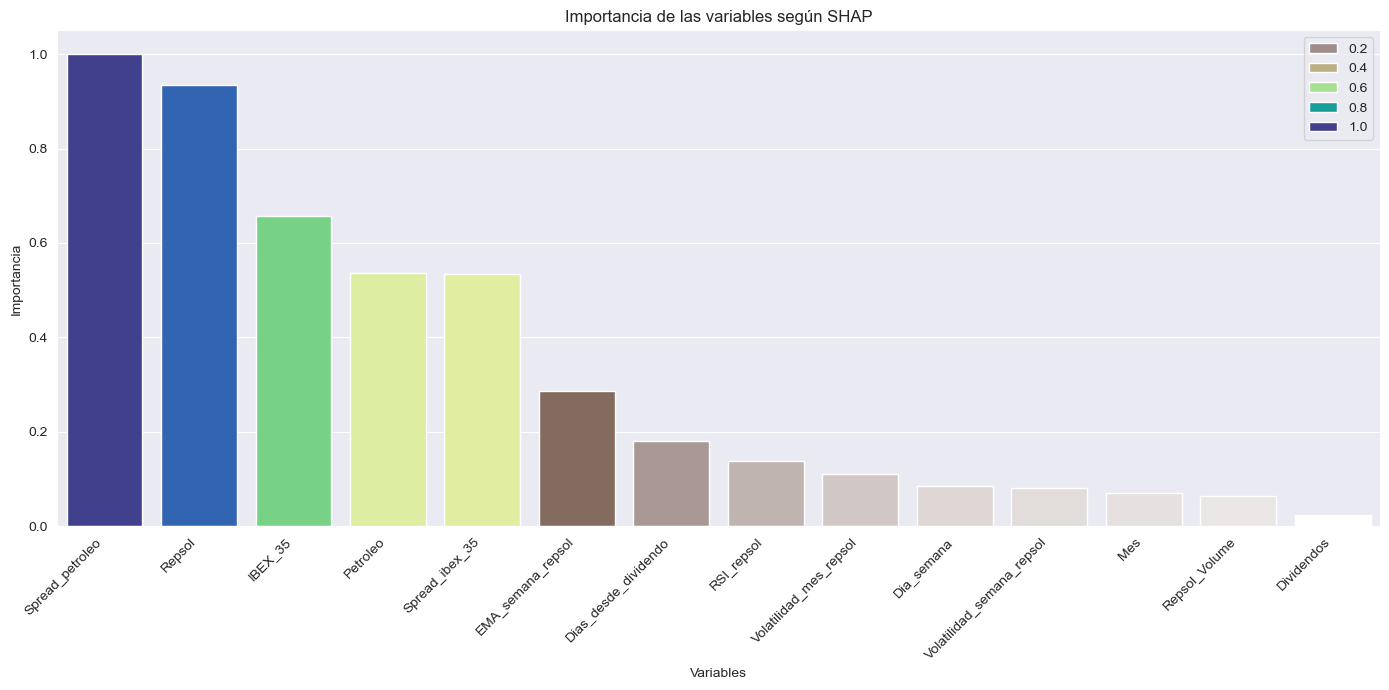

In [68]:
plt.figure(figsize=(14, 7))
sns.barplot(x=importancia_por_variable.index, y=importancia_por_variable.values, palette='terrain_r', hue=importancia_por_variable.values)
plt.title("Importancia de las variables según SHAP")
plt.xlabel("Variables")
plt.ylabel("Importancia")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
variables = list(importancia_por_variable[importancia_por_variable > 0.2].index)
print("Variables seleccionadas:", variables)
# guardar en un csv la lista

with open("data/shap/variables.csv", mode="w", newline="", encoding="utf-8") as archivo:
    escritor = csv.writer(archivo)
    escritor.writerow(variables)

Variables seleccionadas: ['Spread_petroleo', 'Repsol', 'IBEX_35', 'Petroleo', 'Spread_ibex_35', 'EMA_semana_repsol']


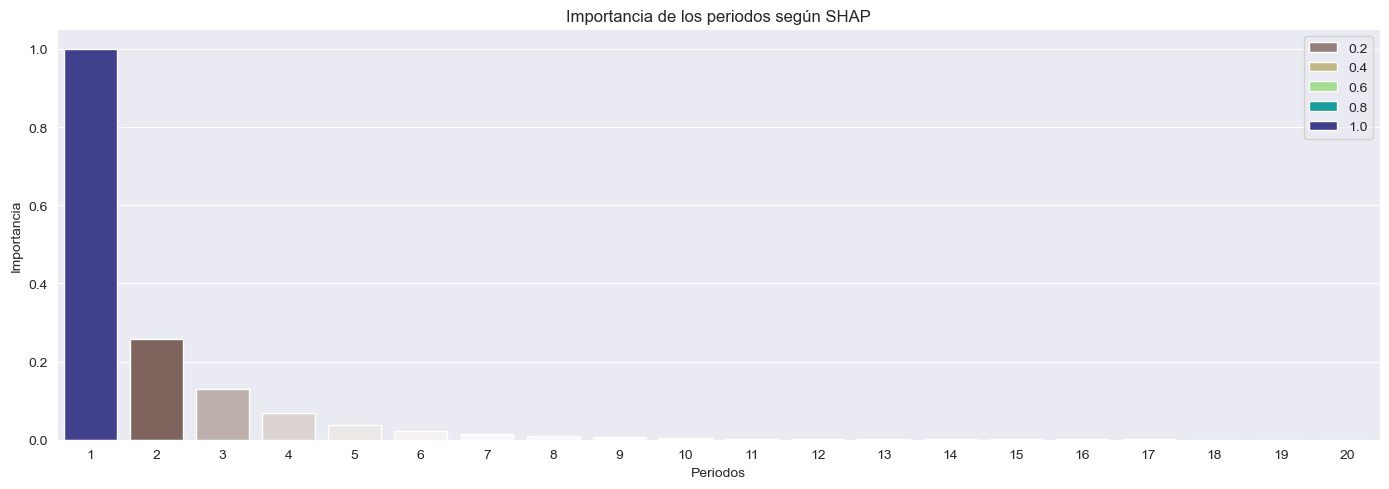

In [73]:
importancia_por_periodo = np.abs(shap_values).sum(axis=(0, 2)) 
importancia_por_periodo = pd.Series(importancia_por_periodo)
importancia_por_periodo.index = importancia_por_periodo.index + 1
importancia_por_periodo = importancia_por_periodo / importancia_por_periodo.max()

plt.figure(figsize=(14, 5))
sns.barplot(x=importancia_por_periodo.index, y=importancia_por_periodo.values, palette='terrain_r', hue=importancia_por_periodo.values)
plt.title("Importancia de los periodos según SHAP")
plt.xlabel("Periodos")
plt.ylabel("Importancia")
plt.tight_layout()
plt.show()

In [88]:
seq_len = importancia_por_periodo[importancia_por_periodo > 0.1].index[-1]
print("Longitud de la secuencia seleccionada:", seq_len)

Longitud de la secuencia seleccionada: 3


In [75]:
df_prescaled = df[variables + ['Repsol_prox_semana']].copy()

train_prescaled = df_prescaled[:int(len(df)*0.7)]
val_prescaled = df_prescaled[int(len(df)*0.7):int(len(df)*0.8)]
test_prescaled = df_prescaled[int(len(df)*0.8):]

X_prescaled_train = train_prescaled.drop(columns=['Repsol_prox_semana']).copy()
y_prescaled_train = train_prescaled['Repsol_prox_semana'].copy()

X_prescaled_val = val_prescaled.drop(columns=['Repsol_prox_semana']).copy()
y_prescaled_val = val_prescaled['Repsol_prox_semana'].copy()

X_prescaled_test = test_prescaled.drop(columns=['Repsol_prox_semana']).copy()
y_prescaled_test = test_prescaled['Repsol_prox_semana'].copy()


scaler_X = StandardScaler()

# Fit and transform X data
X_train_scaled = scaler_X.fit_transform(X_prescaled_train)
X_val_scaled = scaler_X.transform(X_prescaled_val)
X_test_scaled = scaler_X.transform(X_prescaled_test)

joblib.dump(scaler_X, 'modelos/scalers/scaler_x.pkl')

# Fit and transform y data (reshape needed for 1D arrays)
y_train_scaled = scaler_y.transform(y_prescaled_train.values.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_prescaled_val.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_prescaled_test.values.reshape(-1, 1)).flatten()


# Convert scaled arrays back to DataFrames for saving
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_prescaled_train.index, columns=X_prescaled_train.columns)
X_val_scaled_df = pd.DataFrame(X_val_scaled, index=X_prescaled_val.index, columns=X_prescaled_val.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_prescaled_test.index, columns=X_prescaled_test.columns)

# Save scaled data to CSV
X_train_scaled_df.to_csv('data/clean/train_escalado.csv')
X_val_scaled_df.to_csv('data/clean/val_escalado.csv')
X_test_scaled_df.to_csv('data/clean/test_escalado.csv')

# Save y values
pd.Series(y_train_scaled, index=y_prescaled_train.index).to_csv('data/clean/y_train_escalado.csv')
pd.Series(y_val_scaled, index=y_prescaled_val.index).to_csv('data/clean/y_val_escalado.csv')
pd.Series(y_test_scaled, index=y_prescaled_test.index).to_csv('data/clean/y_test_escalado.csv')

# Display first few rows of scaled data
X_train_scaled_df.head()

,Spread_petroleo,Repsol,IBEX_35,Petroleo,Spread_ibex_35,EMA_semana_repsol
Date,,,,,,
2000-09-21,1.209751,0.767166,0.486893,-0.637668,0.691244,0.811804
2000-09-22,1.193763,0.694176,0.594196,-0.764404,0.434399,0.773416
2000-09-25,1.199641,0.666408,0.655776,-0.835234,0.310867,0.738531
2000-09-26,1.197521,0.653714,0.559346,-0.858524,0.409347,0.711026
2000-09-27,1.126282,0.590641,0.560106,-0.859460,0.301783,0.671579


In [76]:
X_train = crear_secuencias(X_train_scaled_df, seq_length=seq_len)
y_train = y_train_scaled[seq_len:]

X_val= crear_secuencias(X_val_scaled_df, seq_length=seq_len)
y_val = y_val_scaled[seq_len:]

X_test= crear_secuencias(X_test_scaled_df, seq_length=seq_len)
y_test = y_test_scaled[seq_len:]

In [77]:
X_tensor_train = torch.from_numpy(X_train).float().to(device)
torch.save(X_tensor_train, 'data/tensor/X_tensor_train.pt')

X_tensor_test = torch.from_numpy(X_test).float().to(device)
torch.save(X_tensor_test, 'data/tensor/X_tensor_test.pt')

X_tensor_val = torch.from_numpy(X_val).float().to(device)
torch.save(X_tensor_val, 'data/tensor/X_tensor_val.pt')

y_tensor_train = torch.from_numpy(y_train).float().to(device)
torch.save(y_tensor_train, 'data/tensor/y_tensor_train.pt')

y_tensor_val = torch.from_numpy(y_val).float().to(device)
torch.save(y_tensor_val, 'data/tensor/y_tensor_val.pt')

y_tensor_test = torch.from_numpy(y_test).float().to(device)
torch.save(y_tensor_test, 'data/tensor/y_tensor_test.pt')

Train_dataset = torch.utils.data.TensorDataset(
    X_tensor_train, 
    y_tensor_train
)
X_tensor_train.shape

torch.Size([4302, 3, 6])

In [78]:
parametros = pd.read_csv('data/grid_search/df_search_results.csv')
parametros.head()

,hidden_size,num_layers,dropout,linear_size,mae_train,mae_val,mape_train,mape_val
0,8,1,0.000,16,0.389159,0.374464,3.374832,3.572816
1,16,2,0.000,2,0.401323,0.374869,3.520614,3.567778
2,8,1,0.125,16,0.413821,0.374922,3.536425,3.551868
3,2,2,0.000,8,0.415853,0.376735,3.618037,3.594119
4,16,4,0.125,16,0.415608,0.377334,3.587630,3.587513


In [79]:
torch.manual_seed(27)
forecast_repsol = torch.load('modelos/gru/forecast_repsol.pt')

C:\Users\rubi6\AppData\Local\Temp\ipykernel_2284\2363222393.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  forecast_repsol = torch.load('modelos/gru/forecast_repsol.pt'

## Evaluación

MAE: 0.4445
MAPE: 3.9155%


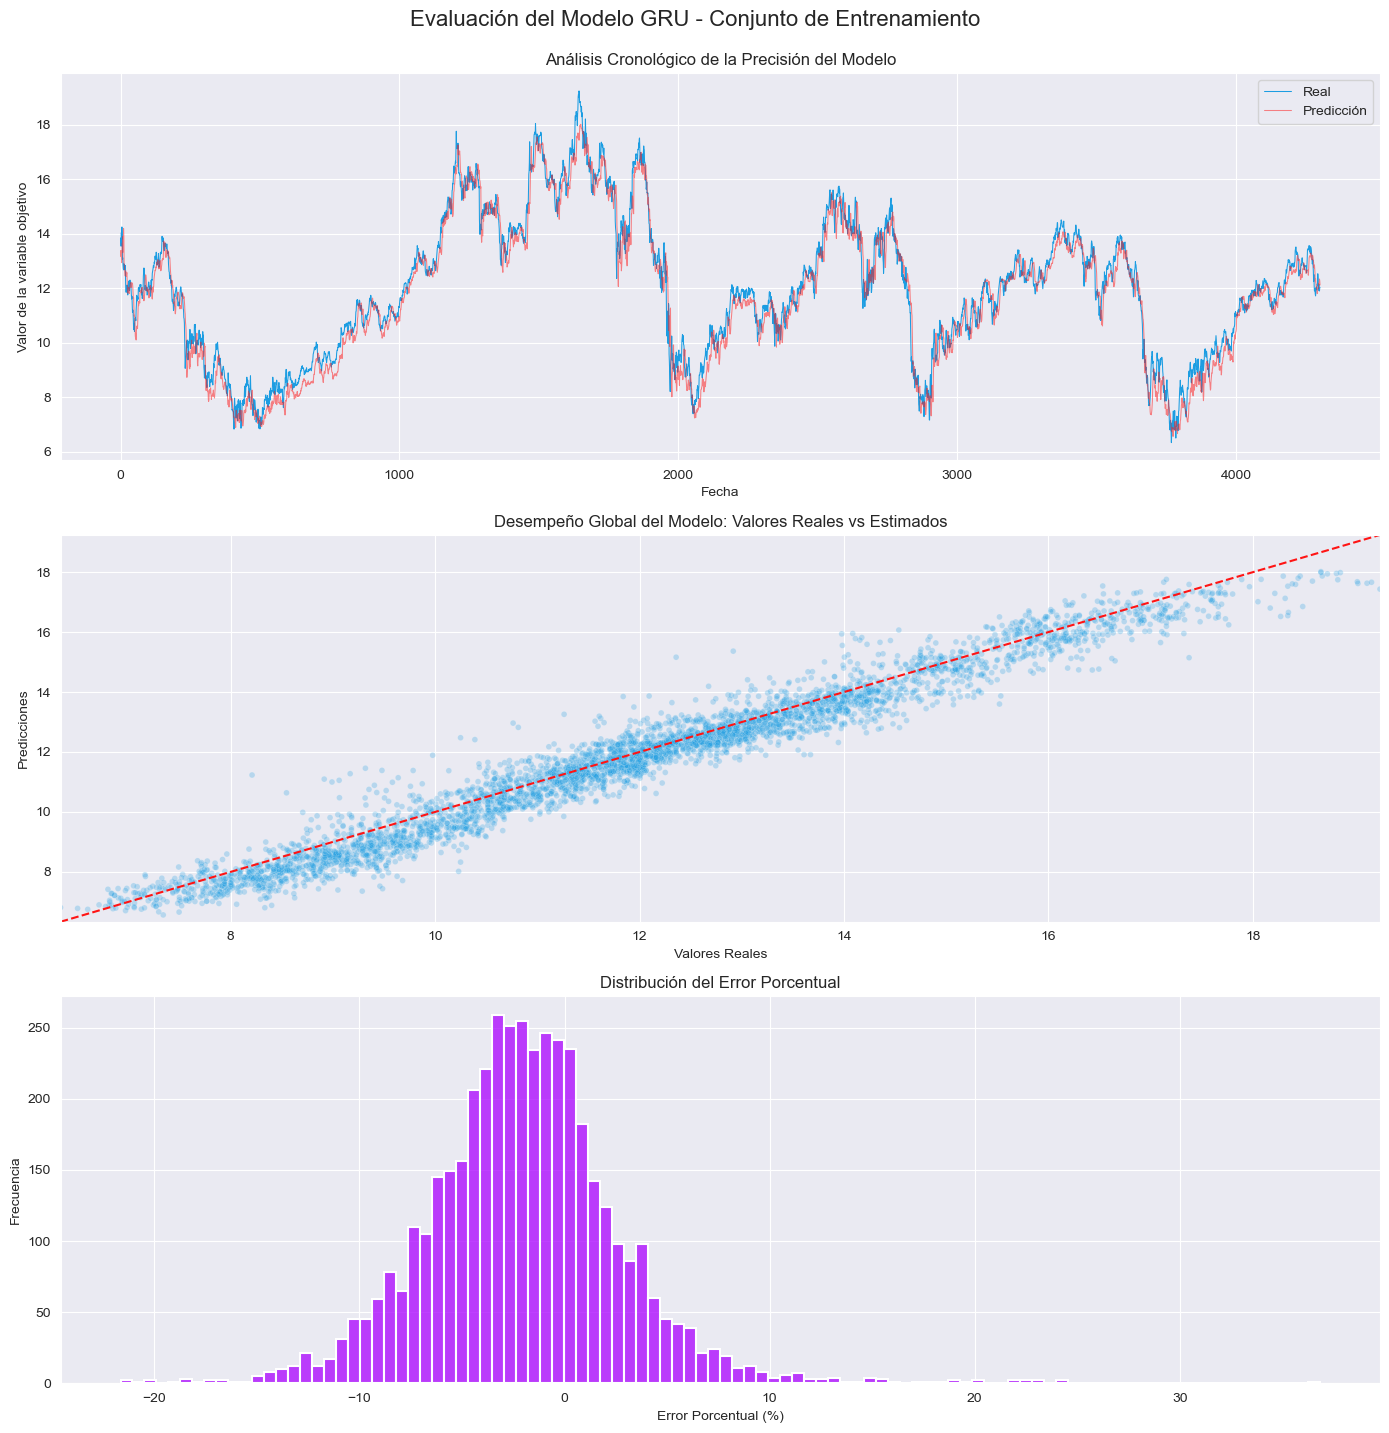

In [80]:
mae_train_gru, mape_train_gru = evaluar_modelo(forecast_repsol, X_tensor_train, y_train, scaler_y, 'Evaluación del Modelo GRU - Conjunto de Entrenamiento')

MAE: 0.3783
MAPE: 3.5450%


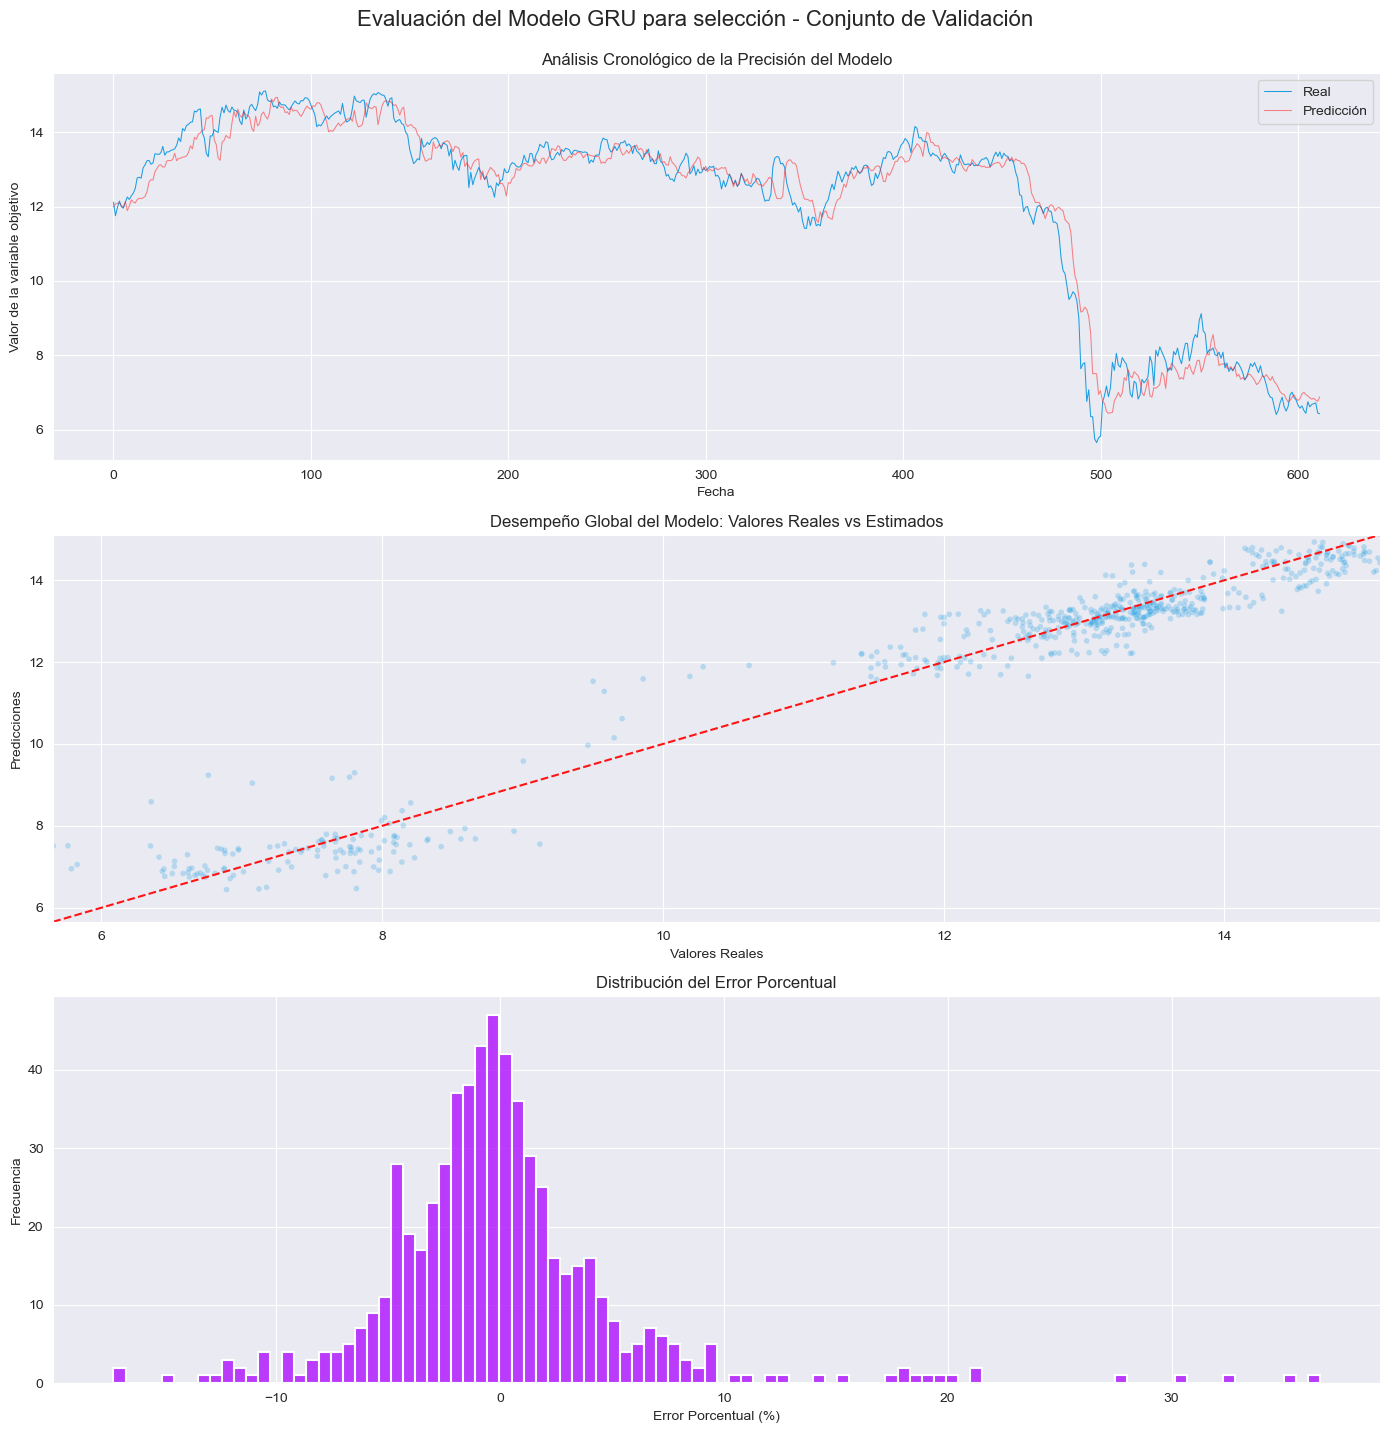

In [81]:
mae_val_gru, mape_val_gru = evaluar_modelo(forecast_repsol, X_tensor_val, y_val, scaler_y, 'Evaluación del Modelo GRU para selección - Conjunto de Validación')

MAE: 0.5099
MAPE: 4.4790%


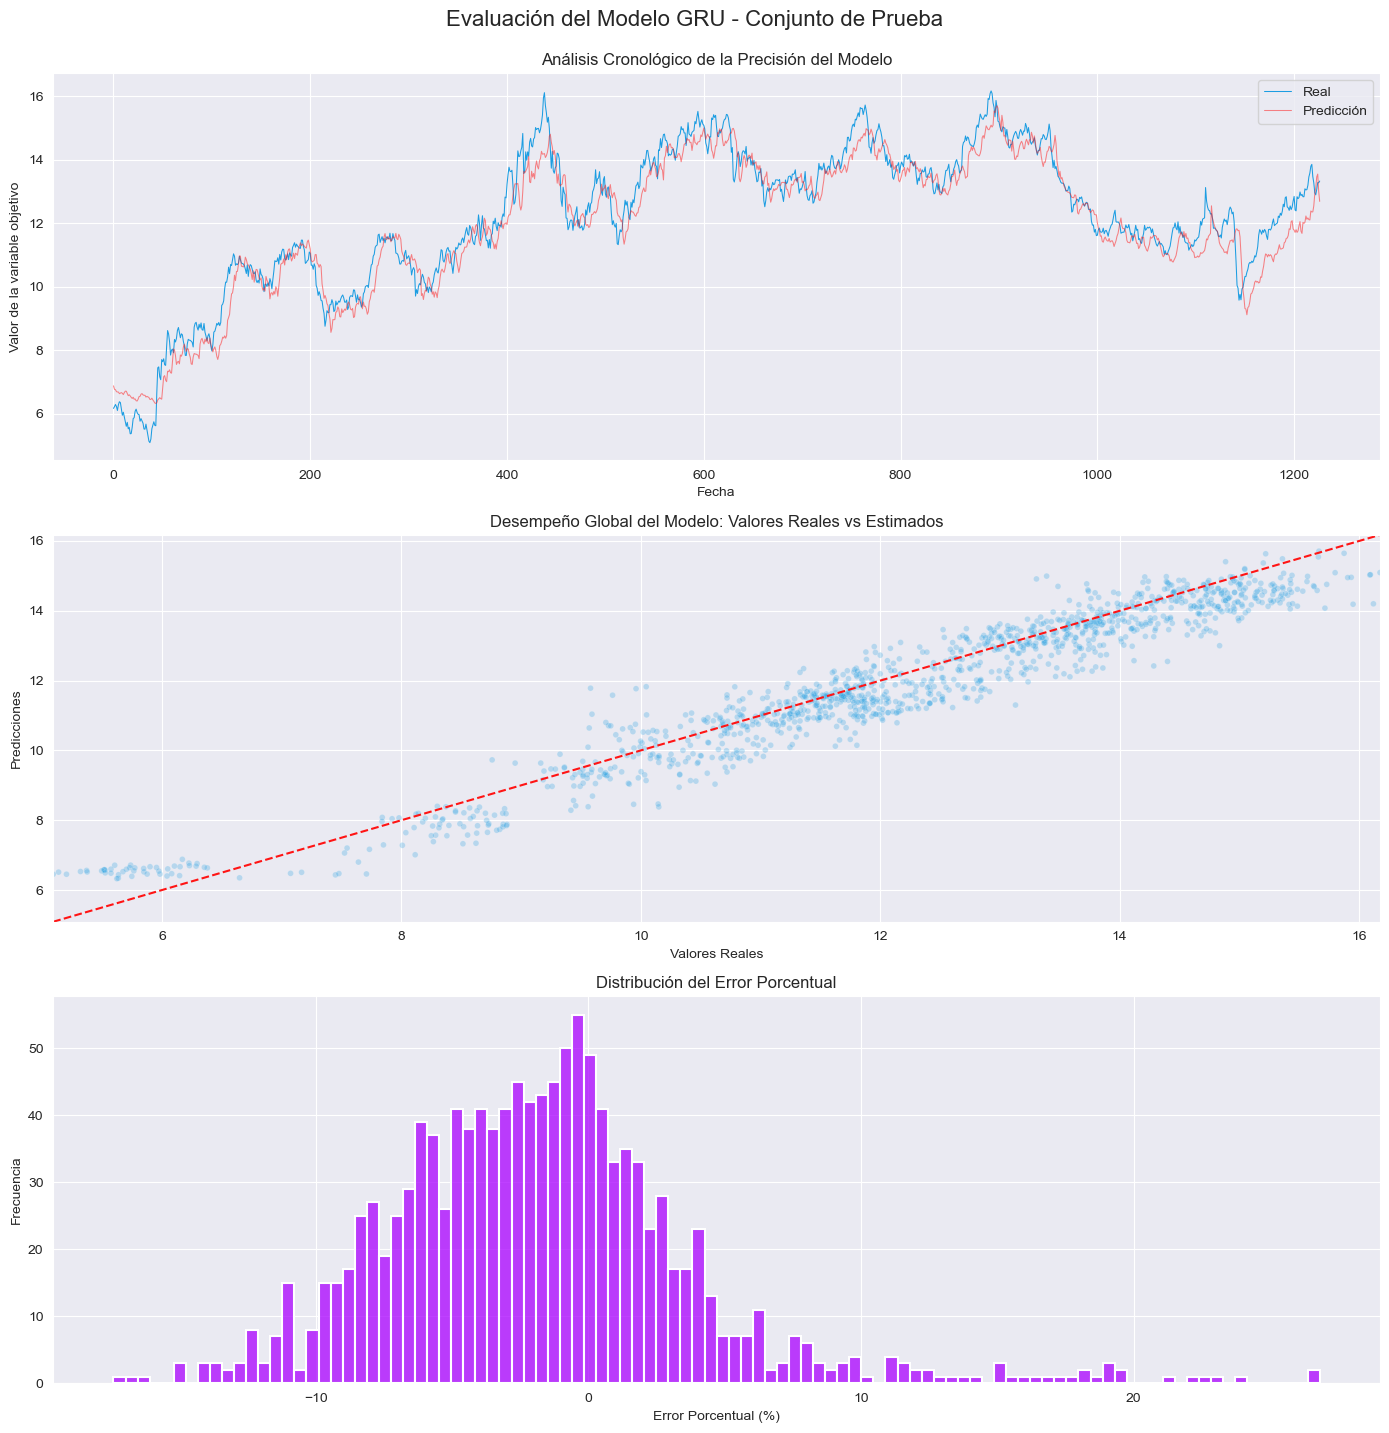

In [82]:
mae_test_gru, mape_test_gru = evaluar_modelo(forecast_repsol, X_tensor_test, y_test, scaler_y, 'Evaluación del Modelo GRU - Conjunto de Prueba')

### Modelo de Persistencia

In [83]:
y_train_shift = X_prescaled_train['Repsol']
y_val_shift = X_prescaled_val['Repsol']
y_test_shift = X_prescaled_test['Repsol']
y_train_shift.shape

(4305,)

In [84]:
mae_train_shift = calcular_mae(y_train_shift, y_prescaled_train)
mae_val_shift = calcular_mae(y_val_shift, y_prescaled_val)
mae_test_shift = calcular_mae(y_test_shift, y_prescaled_test)

mape_train_shift = calcular_mape(y_train_shift, y_prescaled_train)
mape_val_shift = calcular_mape(y_val_shift, y_prescaled_val)
mape_test_shift = calcular_mape(y_test_shift, y_prescaled_test)

print(f'MAE con shift - Entrenamiento: {mae_train_shift:.4f}, Validación: {mae_val_shift:.4f}, Prueba: {mae_test_shift:.4f}')
print(f'MAPE con shift - Entrenamiento: {mape_train_shift:.4f}%, Validación: {mape_val_shift:.4f}%, Prueba: {mape_test_shift:.4f}%')

MAE con shift - Entrenamiento: 0.3480, Validación: 0.3489, Prueba: 0.3822
MAPE con shift - Entrenamiento: 3.0238%, Validación: 3.2201%, Prueba: 3.3076%


### Regresión Logistica

In [85]:
def crear_secuencias_lr(df, seq_length):
    df_copy = df.copy()
    for i in range(seq_length):
        for col in df.columns:
            col_name = f"{col}_{i+1}"
            df_copy[col_name] = df_copy[col].shift(i + 1)
    df_copy.dropna(inplace=True)
    return df_copy

In [86]:
X_train_lr = crear_secuencias_lr(X_train_scaled_df, seq_length=seq_len)
X_val_lr = crear_secuencias_lr(X_val_scaled_df, seq_length=seq_len)
X_test_lr = crear_secuencias_lr(X_test_scaled_df, seq_length=seq_len)
X_train_lr.head()

,Spread_petroleo,Repsol,IBEX_35,Petroleo,Spread_ibex_35,EMA_semana_repsol,Spread_petroleo_1,Repsol_1,IBEX_35_1,Petroleo_1,...,IBEX_35_2,Petroleo_2,Spread_ibex_35_2,EMA_semana_repsol_2,Spread_petroleo_3,Repsol_3,IBEX_35_3,Petroleo_3,Spread_ibex_35_3,EMA_semana_repsol_3
Date,,,,,,,,,,,,,,,,,,,,,
2000-09-26,1.197521,0.653714,0.559346,-0.858524,0.409347,0.711026,1.199641,0.666408,0.655776,-0.835234,...,0.594196,-0.764404,0.434399,0.773416,1.209751,0.767166,0.486893,-0.637668,0.691244,0.811804
2000-09-27,1.126282,0.590641,0.560106,-0.859460,0.301783,0.671579,1.197521,0.653714,0.559346,-0.858524,...,0.655776,-0.835234,0.310867,0.738531,1.193763,0.694176,0.594196,-0.764404,0.434399,0.773416
2000-09-28,1.247815,0.663631,0.591205,-0.932297,0.386486,0.669711,1.126282,0.590641,0.560106,-0.859460,...,0.559346,-0.858524,0.409347,0.711026,1.199641,0.666408,0.655776,-0.835234,0.310867,0.738531
2000-09-29,1.064311,0.515271,0.556498,-0.904367,0.178863,0.618810,1.247815,0.663631,0.591205,-0.932297,...,0.560106,-0.859460,0.301783,0.671579,1.197521,0.653714,0.559346,-0.858524,0.409347,0.711026
2000-10-02,1.159032,0.646177,0.652643,-0.801956,0.280566,0.628689,1.064311,0.515271,0.556498,-0.904367,...,0.591205,-0.932297,0.386486,0.669711,1.126282,0.590641,0.560106,-0.859460,0.301783,0.671579


In [87]:
variables_presentes = X_train_lr.columns.tolist()
variables_presentes = [col for col in variables_presentes if col in X_train_scaled_df.columns]

lr = LinearRegression()
lr.fit(X_train_lr, y_train)

y_train_lr_pred = scaler_y.inverse_transform(lr.predict(X_train_lr).reshape(-1, 1))
y_val_lr_pred = scaler_y.inverse_transform(lr.predict(X_val_lr).reshape(-1, 1))
y_test_lr_pred = scaler_y.inverse_transform(lr.predict(X_test_lr).reshape(-1, 1))

mae_train_lr = calcular_mae(y_prescaled_train[seq_len:].values, y_train_lr_pred)
mae_val_lr = calcular_mae(y_prescaled_val[seq_len:].values, y_val_lr_pred)
mae_test_lr = calcular_mae(y_prescaled_test[seq_len:].values, y_test_lr_pred)

mape_train_lr = calcular_mape(y_prescaled_train[seq_len:].values, y_train_lr_pred)
mape_val_lr = calcular_mape(y_prescaled_val[seq_len:].values, y_val_lr_pred)
mape_test_lr = calcular_mape(y_prescaled_test[seq_len:].values, y_test_lr_pred)

print(f'MAE - Entrenamiento: {mae_train_lr:.4f}, Validación: {mae_val_lr:.4f}, Prueba: {mae_test_lr:.4f}')
print(f'MAPE - Entrenamiento: {mape_train_lr:.4f}%, Validación: {mape_val_lr:.4f}%, Prueba: {mape_test_lr:.4f}%')

MAE - Entrenamiento: 2.8449, Validación: 2.5351, Prueba: 2.4588
MAPE - Entrenamiento: 25.0603%, Validación: 25.1688%, Prueba: 22.7528%


**Observaciones**

`forecast_repsol` obtiene unos resultados muy superiores a los de la regresión logistica, sin embargo no consigue superar al modelo de persistencia


## Conclusión

- Resumen del flujo:
    - Se han obtenido y unificado series temporales de Repsol, petróleo (convertido a €) y factores de mercado, limpiando nulos e homogeneizando husos horarios.
    - Se generaron características de ingeniería relevantes: spread frente a petróleo e IBEX, volatilidades (ventana semanal/mensual), EMA, RSI, días desde el dividendo, mes y día de la semana.
    - Se construyó la variable objetivo como el precio de Repsol a una semana (shift -5) y se eliminaron filas con nulos tras las transformaciones.

- Selección de variables y reducción de secuencia:
    - Se entrenó un modelo GRU ligero y se utilizó SHAP (GradientExplainer) para obtener la importancia por variable y tambien por periodo.
    - A partir de SHAP se seleccionaron las variables más relevantes y la longitud de secuencia (seq_len) óptima para el modelo final.

- Modelado y evaluación:
    - Se realizó una búsqueda de hiperparámetros sobre arquitecturas GRU (variando hidden_size, capas, dropout y tamaño lineal) y se guardaron los mejores modelos y scalers.
    - El modelo final (forecast_repsol.pt) y su predecesor para selección (gru_sel.pt) fueron evaluados en conjuntos de entrenamiento, validación y prueba usando MAE y MAPE; los resultados gráficos y numéricos están generados en las celdas de evaluación.
    - Se implementaron baselines: persistencia (usar el precio actual como predicción a 1 semana) y regresión lineal con variables rezagadas, permitiendo una comparación directa.

- Observaciones y limitaciones:
    - La transformación dólar→euro y la interpolación de volumen fueron necesarias; sin embargo, la conversión introduce dependencia en la calidad de la serie del petróleo.
    - La previsión a una semana está sujeta a ruidos de mercado y eventos exógenos (anuncios macro), que no están modelados explícitamente.

- Próximos pasos:
    - Probar ensamblado de modelos (GRU + modelos tradicionales como XGB) y aumentación de features macroeconómicas (tipos de interes de la FED o el BCE, inventarios de petróleo, noticias, competidores, etc) para capturar shocks.

El pipeline construye un flujo reproducible desde la adquisición hasta la evaluación del modelo; SHAP ha permitido reducir dimensionalidad y enfocar la arquitectura GRU en las señales más relevantes. Para llevarlo a producción conviene validar numéricamente la ventaja frente a los baselines y robustecer las features macro.